Importing required packages

In [2]:
from __future__ import unicode_literals

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from collections import Counter
from textblob import TextBlob
import re
import nltk
import xgboost as xgb
import numpy as np
import collections
import operator
import itertools
import os


from nltk.corpus import stopwords
import nltk.stem.snowball
st = nltk.stem.snowball.SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer('english')

from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score ,confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.svm import SVC
from sklearn import utils

from yellowbrick.text import FreqDistVisualizer

import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import models
from gensim.models.doc2vec import TaggedDocument
import pyLDAvis.gensim as gensimvis

from itertools import islice

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras import utils

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en')

from wordcloud import WordCloud 

import plotly 
plotly.tools.set_credentials_file(username='avinashok', api_key='SZBL9GagG9yPYCwfSuDc')
import plotly.plotly as py
import plotly.graph_objs as go

### Exploratory Data Analysis

Variable Standardization

In [3]:
#Directories
dataDirectory = "../Data/"


Reading Data file

In [4]:
# reading data file  
df = pd.read_csv(dataDirectory+'CustomerInteractionData.csv')

#Randomly shuffling data
df = df.sample(len(df))

#Copying the Raw comment column for Future Use
df['CustomerInteractionText'] = df['CustomerInteractionRawText']

#Checking the initial 5 rows
df.head(5)

,RecordID,CustomerInteractionRawText,AgentAssignedTopic,LocationID,CallDurationSeconds,AgentID,CustomerID,CustomerInteractionText
55,1890096,Deactivating current special plans due to insu...,Deactivate,4.0,17.0,LMpPq,M7FMT,Deactivating current special plans due to insu...
60,1890101,Ali want to change plans. He suggested to acti...,Change Plans,4.0,20.0,Z5shy,N5Om3,Ali want to change plans. He suggested to acti...
22,1890063,Customer can't afford monthly bills as they ar...,High Bill,9.0,9.0,oRThR,7R2hF,Customer can't afford monthly bills as they ar...
98,1890139,Checking IMEI status.,Others,8.0,5.0,rBM1s,P7kiq,Checking IMEI status.
7,1890048,Kumar called to ask about his porting status. ...,Port Out,0.0,10.0,0MmQN,Y2jwL,Kumar called to ask about his porting status. ...


In [5]:
#Objects Used
commentTextColumn = 'CustomerInteractionText'
agentAssignedColumn = 'AgentAssignedTopic'
locationID = 'LocationID'
callDuration = 'CallDurationSeconds' #In Seconds
agentID = 'AgentID'
customerID = 'CustomerID'
rawText = 'CustomerInteractionRawText'

### Checking Data Quality

By doing a Data Quality Check we are:

- Identifying a unique column which can be assigned as a Primary Key column (incase it wasn't specified initially.)
- Making sure all the columns are having the required datatypes
- Calculating the Null Values, Duplicate values, etc. (Maximum, Minimum, Range in case its a numeric column.).
- Creating visualizations to understand the Data Quality level of input data.

In [6]:
# Identifying Primary Key
df.shape 
print("Number of Columns in the Dataset = " + str(len(df.columns)))
df.columns.to_list()
uniqueColumns=[]
for col in df.columns.to_list():
    if len(df[str(col)].unique())==df.shape[0]:
        uniqueColumns.append(col)
if len(uniqueColumns)==1:
    primaryKeyColumn = str(uniqueColumns[0])
    print("Primary Key = "+primaryKeyColumn)

Number of Columns in the Dataset = 8
Primary Key = RecordID


In [7]:
# Checking Datatypes of each columns in the dataset
print(df.dtypes)

# Specifying datatypes we want for each column
dataTypeDictionary = {
    primaryKeyColumn: 'int64',
    commentTextColumn: 'object',
    rawText:'object',
    agentAssignedColumn: 'object',             
    locationID: 'int64',
    callDuration: 'int64',
    agentID: 'object',
    customerID: 'object'
    
 }

RecordID                        int64
CustomerInteractionRawText     object
AgentAssignedTopic             object
LocationID                    float64
CallDurationSeconds           float64
AgentID                        object
CustomerID                     object
CustomerInteractionText        object
dtype: object


In [8]:
duplicatesCount = {}
for col in df.columns.to_list():
    duplicatesCount[col] = [((df.duplicated(col).sum()/len(df))*100),100-((df.duplicated(col).sum()/len(df))*100)]

nullCounter = {}
for col in df.columns.to_list():
    count = 0
    for cell in df[str(col)]:
        if cell=='?' or cell=="":   # or len(str(cell))==1
            count= count +1
    nullCounter[col]=[float(count/len(df))*100,100-float(count/len(df))*100]

In [9]:
def dataQualityCheck(checkName, columnName):
    if checkName == "Null Values":
        # create data
        names='Null Values', 'Non Null Values',
        size=np.array(nullCounter[columnName])
        print("Null Values Data Quality Check for "+str(columnName))
        def absolute_value(val):
            a  = np.round(val/100.*size.sum(), 0)
            return a
        # Create a circle for the center of the plot
        my_circle=plt.Circle( (0,0), 0.7, color='white')

        # Custom colors --> colors will cycle
        plt.pie(size, labels=names, colors=['red','green'],autopct=absolute_value)
        p=plt.gcf()
        p.gca().add_artist(my_circle)
        plt.show();
    elif checkName =="Duplicates": 
                # create data
        names='Duplicate Values', 'Unique Values Values',
        size=np.array(duplicatesCount[columnName])
        print("Duplicate Value Data Quality check for "+str(columnName))
        def absolute_value(val):
            a  = np.round(val/100.*size.sum(), 0)
            return a
        # Create a circle for the center of the plot
        my_circle=plt.Circle( (0,0), 0.7, color='white')

        # Custom colors --> colors will cycle
        plt.pie(size, labels=names, colors=['red','green'],autopct=absolute_value)
        p=plt.gcf()
        p.gca().add_artist(my_circle)
        plt.show();
    elif checkName == "Details":
        print("Details of the Column: \n ")
        print("Original Datatype should be "+dataTypeDictionary[columnName]+"\n")
        print("Datatype in the data is "+str(df[str(columnName)].dtypes)+"\n")
    elif checkName == "Range":
        if str(df[str(columnName)].dtypes)=='int64' or str(df[str(columnName)].dtypes)=='datetime64[ns]':
            print("Maximum Value is "+str(df[str(columnName)].max())+" \n ")
            print("Minimum Value is "+str(df[str(columnName)].min()))
        else:
            print("Since the Datatype of column "+str(columnName)+" is not numeric in the given data, Range cannot be calculated.")
    
    
def dQexecute(columnName):
    print("\n Name of the Column "+str(columnName)+"\n \n")
    dataQualityCheck("Details",columnName)
    dataQualityCheck("Null Values",columnName)
    dataQualityCheck("Duplicates",columnName)
    dataQualityCheck("Range",columnName)
    print("*****************")


 Name of the Column RecordID
 

Details of the Column: 
 
Original Datatype should be int64

Datatype in the data is int64

Null Values Data Quality Check for RecordID


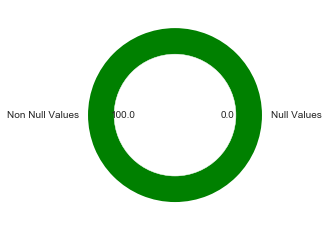

Duplicate Value Data Quality check for RecordID


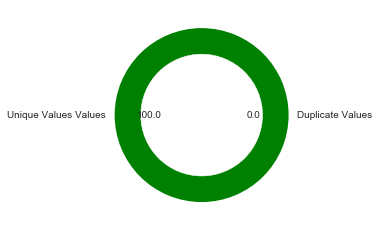

Maximum Value is 1890143 
 
Minimum Value is 1890041
*****************

 Name of the Column CustomerInteractionRawText
 

Details of the Column: 
 
Original Datatype should be object

Datatype in the data is object

Null Values Data Quality Check for CustomerInteractionRawText


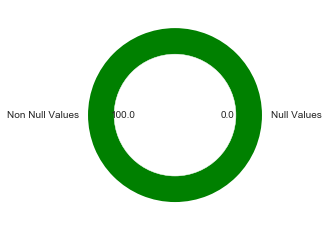

Duplicate Value Data Quality check for CustomerInteractionRawText


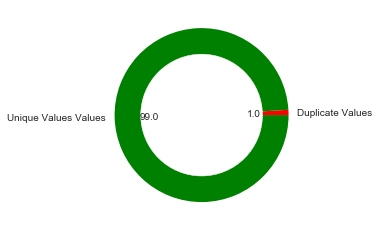

Since the Datatype of column CustomerInteractionRawText is not numeric in the given data, Range cannot be calculated.
*****************

 Name of the Column AgentAssignedTopic
 

Details of the Column: 
 
Original Datatype should be object

Datatype in the data is object

Null Values Data Quality Check for AgentAssignedTopic


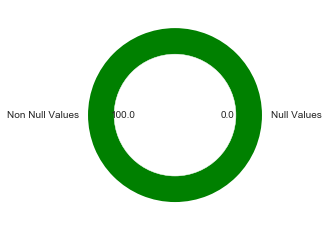

Duplicate Value Data Quality check for AgentAssignedTopic


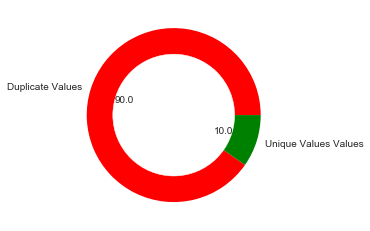

Since the Datatype of column AgentAssignedTopic is not numeric in the given data, Range cannot be calculated.
*****************

 Name of the Column LocationID
 

Details of the Column: 
 
Original Datatype should be int64

Datatype in the data is float64

Null Values Data Quality Check for LocationID


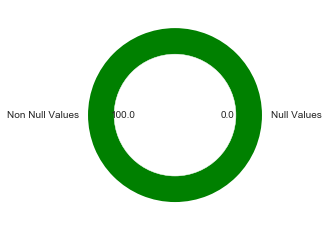

Duplicate Value Data Quality check for LocationID


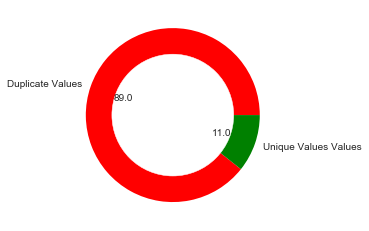

Since the Datatype of column LocationID is not numeric in the given data, Range cannot be calculated.
*****************

 Name of the Column CallDurationSeconds
 

Details of the Column: 
 
Original Datatype should be int64

Datatype in the data is float64

Null Values Data Quality Check for CallDurationSeconds


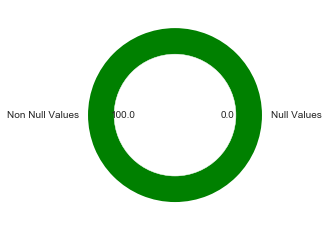

Duplicate Value Data Quality check for CallDurationSeconds


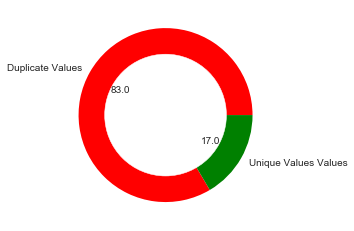

Since the Datatype of column CallDurationSeconds is not numeric in the given data, Range cannot be calculated.
*****************

 Name of the Column AgentID
 

Details of the Column: 
 
Original Datatype should be object

Datatype in the data is object

Null Values Data Quality Check for AgentID


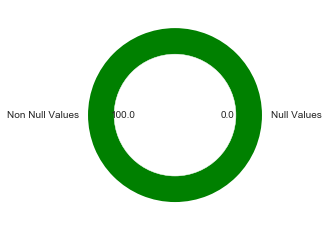

Duplicate Value Data Quality check for AgentID


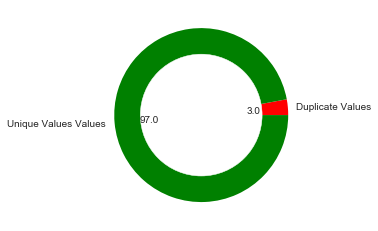

Since the Datatype of column AgentID is not numeric in the given data, Range cannot be calculated.
*****************

 Name of the Column CustomerID
 

Details of the Column: 
 
Original Datatype should be object

Datatype in the data is object

Null Values Data Quality Check for CustomerID


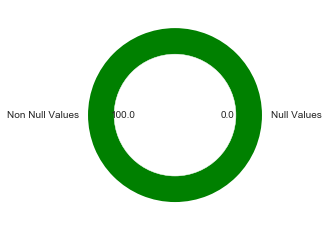

Duplicate Value Data Quality check for CustomerID


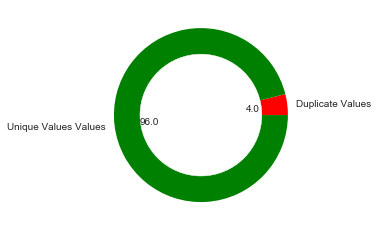

Since the Datatype of column CustomerID is not numeric in the given data, Range cannot be calculated.
*****************

 Name of the Column CustomerInteractionText
 

Details of the Column: 
 
Original Datatype should be object

Datatype in the data is object

Null Values Data Quality Check for CustomerInteractionText


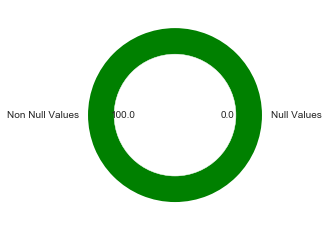

Duplicate Value Data Quality check for CustomerInteractionText


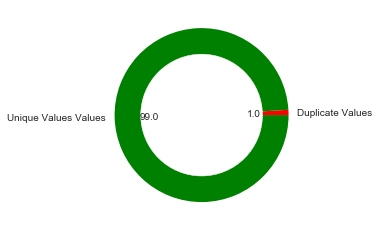

Since the Datatype of column CustomerInteractionText is not numeric in the given data, Range cannot be calculated.
*****************


In [10]:
for col in df.columns.to_list():
    dQexecute(col)

### Agent Assigned Topic Distribution Analysis

For visualizing Topic distribution, we use the package [plotly](https://plot.ly/) which makes the bar charts more interactive.

In [11]:
z = {}
uniqueTopics = list(df[agentAssignedColumn].unique())
for i in uniqueTopics:
    z[i]=i

data = [go.Bar(x = df[agentAssignedColumn].map(z).unique(),y = df[agentAssignedColumn].value_counts().values,
        marker= dict(colorscale='Jet',color = df[agentAssignedColumn].value_counts().values),text='Number of Calls for this reason')]

layout = go.Layout(title='Reasonwise Call Distribution')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='TelecomCallDistribution')

### Analyzing the Word Count for each Reasons

- We can check average Word count for each reasons. At times taking Median word count might also be useful.

In [12]:
df['totalwords'] = df[commentTextColumn].str.split().str.len()
def reasonCodeLevelWordCount(reasonCode, parameter):
    dfReasonCodeSubset = df[df[agentAssignedColumn]==reasonCode]
    if parameter == 'mean':
        return float(dfReasonCodeSubset.describe()['totalwords'][1])
    elif parameter == 'median':
        return float(dfReasonCodeSubset.describe()['totalwords'][5])

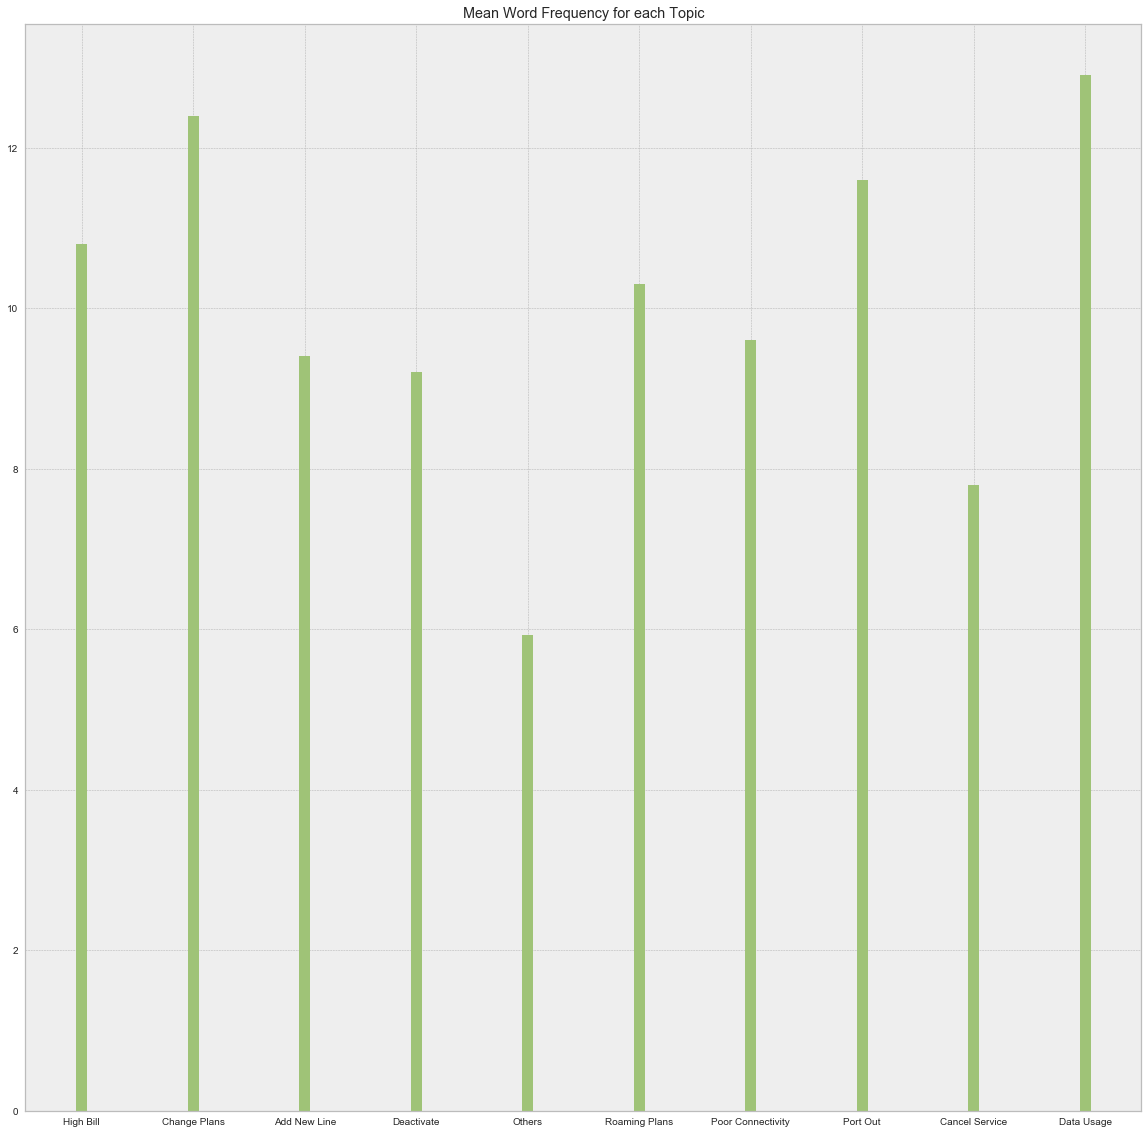



 ******************** 

 


In [13]:
# Mean Word Count
reasonCodeDict = {}
for topic in uniqueTopics:
    reasonCodeDict[str(topic)]=float(reasonCodeLevelWordCount(topic, 'mean'))
plt.figure(figsize=(20,20))
plt.title("Mean Word Frequency for each Topic", fontdict=None, loc='center')
plt.bar(reasonCodeDict.keys(), reasonCodeDict.values(), width = 0.1  , color='g')
plt.show()

print("\n\n ******************** \n\n ")

# #Median Word Count (Optional)
# reasonCodeDict = {}
# for topic in uniqueTopics:
#     reasonCodeDict[str(topic)]=float(reasonCodeLevelWordCount(topic, 'median'))
# plt.figure(figsize=(20,20))
# plt.title("Median Word Frequency for each Topic", fontdict=None, loc='center')
# plt.bar(reasonCodeDict.keys(), reasonCodeDict.values(), width = 0.1  , color='g')
# plt.show()

### Visualize Token (vocabulary) Frequency Distribution Before Text Preprocessing

Visualizing frequency distribution of top words helps us in two ways:

- Determine which words needs to be removed & devising a process flow of cleaning the text.
- Comparing the Frequency distribution "Before" & "After" Text Preprocessing gives us a visual idea about how well we are cleaning the data for modelling.

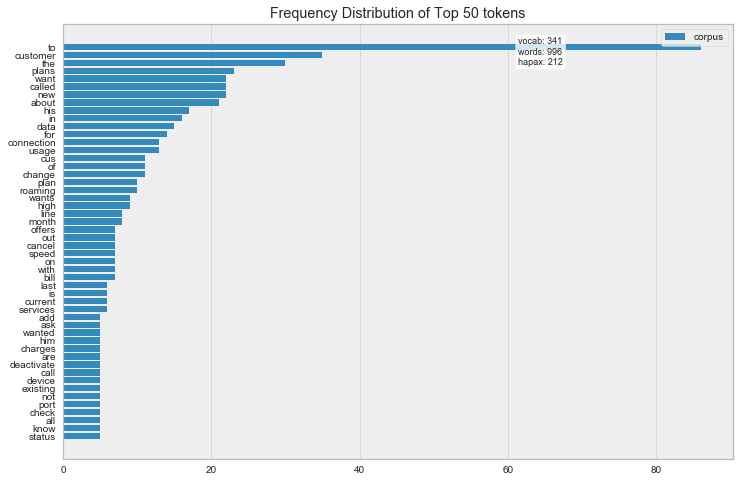

In [14]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df[commentTextColumn])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## Text Preprocessing

In Text Preprocessing, we are performing multiple Natural Language Processing techniques. The idea is to get noise-free standardized text which can be taken for used readily for Modelling. Steps of Preprocessing largely depends on the dataset we are dealing with. In this case the Text Preprocessing comprises of the following steps:


- Object Standardization: Since the free text we have were written by Call Centre agents, they use a lot of domain specific Short Hands, abbreviations, etc. which are not present in any standard lexical dictionaries. But then, at certain times, they write the full form or complete word. Object Standardization strike a balance between these & use a same form of word through out the dataset.


- Named Entity Recognition(NER): Detecting names of 'Person', 'Location', 'Product' etc. and removing them from the dataset as they don't specifically add much value to our final model. (Note: There are cases where such entities are important & should be retained in some format.). We use [SpaCy](https://spacy.io/usage/linguistic-features) for NER.


- Other Language Identification: Since the data we have comes from different locations, there could be a possibility of other languages present in the data. We use `spacy_langdetect` for identifying them and removing them.


- Alphanumeric removal: Since this is Telecom Call centre data, there are a lot of alphanumeric words involved. For eg: 3G, 20MBps, agentID: '4ap2X', etc. We can keep it or remove it as per requirement. 


- Text Cleaning: Next we remove all the special characters, ASCII characters, numbers, single character words, etc.


- Autocorrection: The agent comments might have a lot of spelling mistakes, typos etc.  We try to correct atleast some of them using `TextBlob` Autocorrection.


- Lexicon Normalization: We also normalize multiple representations of a word to its etymological root form. For eg: 'wanted', 'wanting', 'want' becomes > 'want'

After this we perform the following operations on the dataset:

- Remove null comments.
- Remove duplicate comments (keeping its first occurance.)
- Remove comments with just one word.

### Object Standardization

In [15]:
%%time

abbrevationDictionary = {'Cus': 'customer', 'cus': 'customer',
                        'Xferred':'transferred', 'xferred': 'transferred'} 

#Function to Standardize Text
def objectStandardization(input_text):
    words = str(input_text).split() 
    new_words = [] 
    for word in words:
        word = re.sub('[^A-Za-z0-9\s]+', ' ', word) #remove special characters
        if word.lower() in abbrevationDictionary:
            word = abbrevationDictionary [word.lower()]
        new_words.append(word) 
    new_text = " ".join(new_words) 
    return new_text

df[commentTextColumn] = df[commentTextColumn].apply(objectStandardization)

print(df[commentTextColumn].head(5))

23       Want Senior citizen discount in monthly bills 
65    Customer wants to change plan to 3G  His curre...
63    Plan changed  customer happy about new plans  ...
49              Newly added line not getting any calls 
53    Veena wants to deactivate the plan due to unav...
Name: CustomerInteractionText, dtype: object
Wall time: 9.98 ms


Named Entity Recognition

In [16]:
%%time

# Function to extract Names of persons, organizations, locations, products etc. from the dataset
def entityCollector(df):
    listOfNames = []
    for index, row in df.iterrows():
        doc = nlp(row[str(commentTextColumn)])
        fil = [(i.label_.lower(), i) for i in doc.ents if i.label_.lower() in ["person", "gpe", "product"]] # Extracts Person Names, Organization Names, Location, Product names
        if fil:
            listOfNames.append(fil)
        else:
            continue
    flat_list = [item for sublist in listOfNames for item in sublist]
    entityDict = {}
    for a, b in list(set(flat_list)): 
        entityDict.setdefault(a, []).append(b)
    return entityDict

entityDict = entityCollector(df)

print("\n Types of entities present in the data are: "+", ".join(list(entityDict.keys()))+" \n")



 Types of entities present in the data are: gpe, person 

Wall time: 1.62 s


Creating a custom Stop Word List

In [17]:
%%time
for entity in list(entityDict.keys()):
    entityDict[entity] = [str(i) for i in entityDict[entity]]

ignoreWords = []
for key in entityDict.keys():
    ignoreWords.append(entityDict[key])
ignoreWords = [item for sublist in ignoreWords for item in sublist]

print("Number of words in Custom Stopword list = "+str(len(ignoreWords)))

Number of words in Custom Stopword list = 18
Wall time: 2.99 ms


Identify the Language Distribution

Some sample other language texts: 

[1890085, 'Add a new line.', 'Add New Line', 8.0, 5.0, '8ysiF', 'wXMyg', 'Add a new line ', 4, 'cy']
[1890064, 'Want Senior citizen discount in monthly bills.', 'High Bill', 7.0, 18.0, 'ILMzl', 'TX2Iq', 'Want Senior citizen discount in monthly bills ', 7, 'en']
[1890143, 'Se verificaron nuevas aplicaciones en el mercado.', 'Others', 7.0, 10.0, '4ntG8', '9a6f9', 'Se verificaron nuevas aplicaciones en el mercado ', 7, 'es']
[1890142, '#call?', 'Others', nan, nan, nan, nan, ' call ', 1, 'it']
[1890131, 'Customer demise.', 'Others', 7.0, 8.0, '5HHnN', 'svkC5', 'Customer demise ', 2, 'pt']
Wall time: 3.16 s


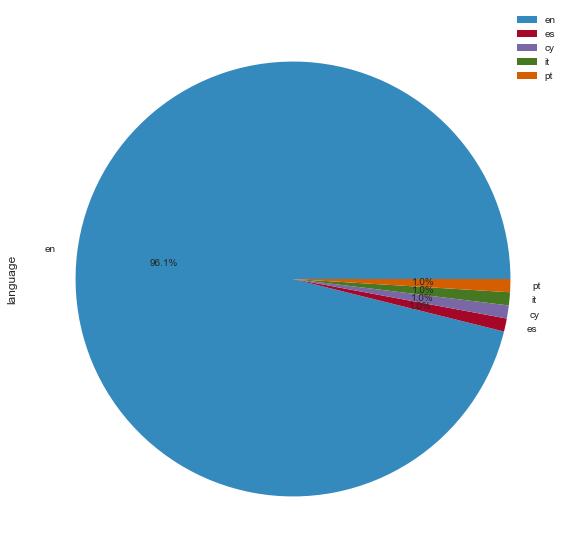

In [18]:
%%time
def languageDistribution(df):
    nlp = spacy.load("en")
    nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
    df['language']=''
    language = []
    for index, row in df.iterrows():
        text = row[str(commentTextColumn)]
        doc = nlp(text)
        language.append(str(doc._.language['language']))
    df['language'] = language
    return df

df = languageDistribution(df)
langDict = df.groupby('language')[str(primaryKeyColumn)].nunique().to_dict()

otherLanguagesList = list(langDict.keys()).remove('en')
print("Some sample other language texts: \n")
for lang in list(langDict.keys()):
    print(str(df[df['language']==str(lang)].values.tolist()[0]))

##Plot a Pie Distribution of Language Distribution
bin_percent = pd.DataFrame(df['language'].value_counts(normalize=True) * 100)
plot = bin_percent.plot.pie(y='language', figsize=(10, 10), autopct='%1.1f%%')

#Dropping only the row with Spanish text
df = df.drop(df[df['language'] == 'es'].index);

Identify Words which contains numbers in it

How many top words do you want? maximum= 3 
 3
{'3g': 3, '1mbps': 2, '935468r911': 1}


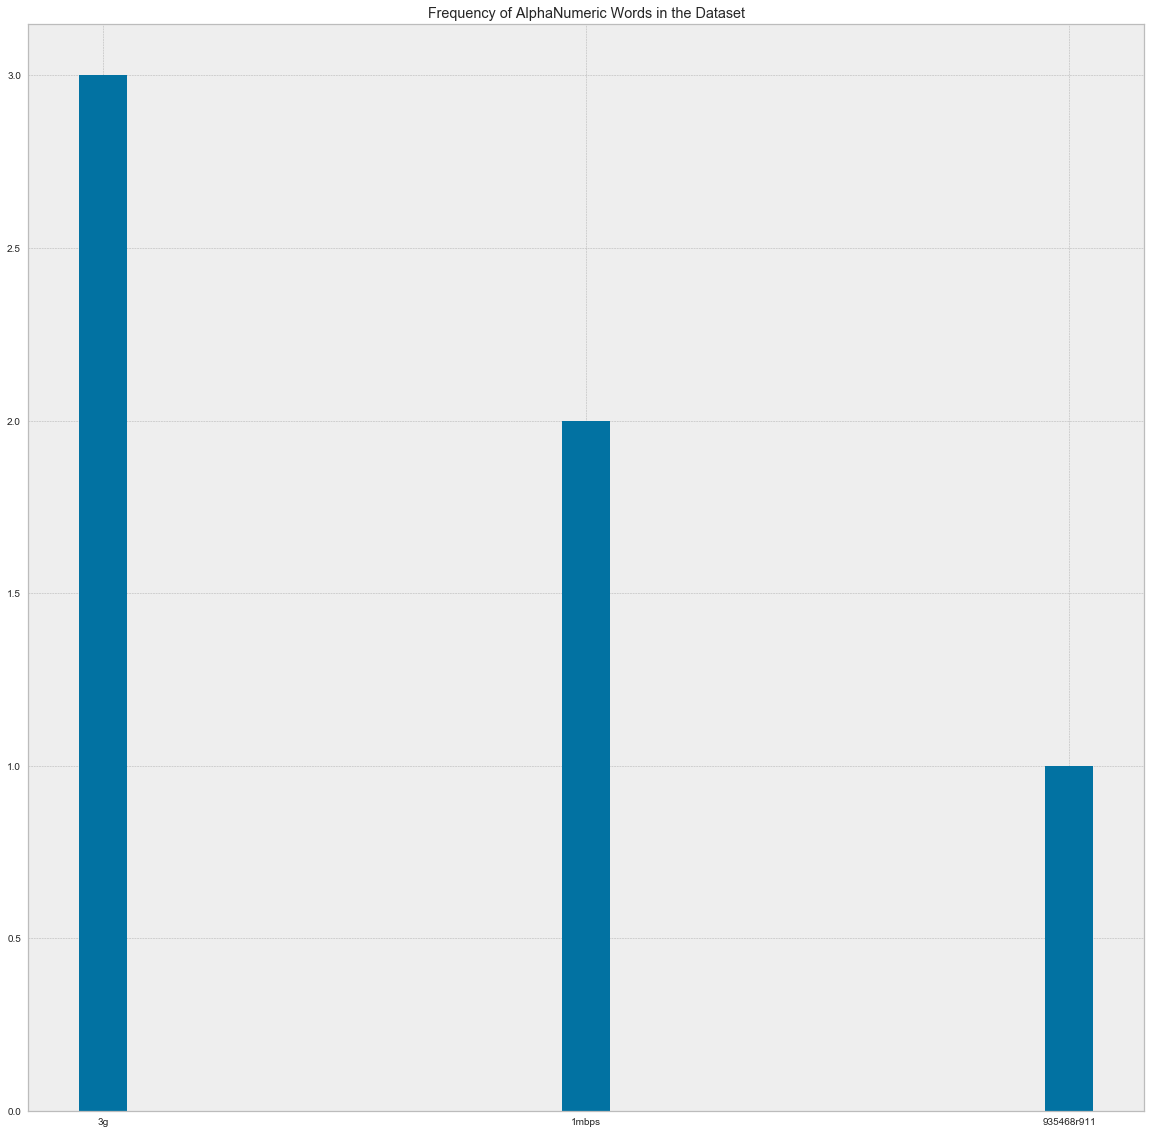

Wall time: 2.58 s


In [19]:
%%time
#Function to extract Alpha numeric words
def alphanumericExtractor(input_text):
    words = str(input_text).split()
    alphanumericWordlist = []
    for word in words:
        word = re.sub('[^A-Za-z0-9\s]+', '', word.lower()) #remove special characters
        word = re.sub(r'[^\x00-\x7F]+',' ', word) # remove ascii
        if not word.isdigit() and any(ch.isdigit() for ch in word):
            alphanumericWordlist.append(word)
        else:
            continue
    return alphanumericWordlist

#Function to get the frequency of Alphanumeric words in the data
def alphanumericFrequency(df, commentTextColumnName):
    alphanumericWordsList = []
    for index, row in df.iterrows():
        if alphanumericExtractor(row[str(commentTextColumnName)]):
            alphanumericWordsList.append(alphanumericExtractor(row[str(commentTextColumnName)]))
        else:
            continue
    flat_list = [item for sublist in alphanumericWordsList for item in sublist]
    counts = Counter(flat_list)
    countsdict = dict(counts)
    return countsdict

# Final list of alphanumeric words
alphanumericWordFreqDict = alphanumericFrequency(df, commentTextColumn)
    
# To plot the distribution
totalWordcount = len(alphanumericWordFreqDict)

topWordCount = input('How many top words do you want? maximum= '+str(totalWordcount)+ ' \n ')
# topWordCount = totalWordcount

alphanumericWordFreqDictTop = dict(sorted(alphanumericWordFreqDict.items(), key=operator.itemgetter(1), reverse=True)[:int(topWordCount)])
print(alphanumericWordFreqDictTop)

plt.figure(figsize=(20,20))
plt.title('Frequency of AlphaNumeric Words in the Dataset', fontdict=None, loc='center')
plt.bar(alphanumericWordFreqDictTop.keys(), alphanumericWordFreqDictTop.values(), width = 0.1  , color='b');
plt.show();

#Updating Custom stopword list with Alphanumeric words
ignoreWords = ignoreWords + list(alphanumericWordFreqDict.keys())

Text Cleaning

In [20]:
def clean_text(newDesc):
    newDesc = re.sub('[^A-Za-z\s]+', '', newDesc) #remove special characters
    newDesc = re.sub(r'[^\x00-\x7F]+','', newDesc) # remove ascii
    newDesc = ' '.join( [w for w in newDesc.split() if len(w)>1] )  
    newDesc = newDesc.split()
    cleanDesc = [str(w) for w in newDesc if w not in ignoreWords] #remove entity names, alphanumeric words
    return ' '.join(cleanDesc)

df[commentTextColumn] = df[commentTextColumn].apply(clean_text)
df.head()

,RecordID,CustomerInteractionRawText,AgentAssignedTopic,LocationID,CallDurationSeconds,AgentID,CustomerID,CustomerInteractionText,totalwords,language
23,1890064,Want Senior citizen discount in monthly bills.,High Bill,7.0,18.0,ILMzl,TX2Iq,Want Senior citizen discount in monthly bills,7,en
65,1890106,Customer wants to change plan to 3G. His curre...,Change Plans,8.0,7.0,kwFhJ,la1nn,Customer wants to change plan to His current p...,18,en
63,1890104,Plan changed. Cus happy about new plans & offe...,Change Plans,8.0,5.0,VMSRM,Yvo5x,Plan changed customer happy about new plans of...,11,en
49,1890090,Newly added line not getting any calls.,Add New Line,2.0,17.0,zxbV5,zb9YI,Newly added line not getting any calls,7,en
53,1890094,Veena wants to deactivate the plan due to unav...,Deactivate,6.0,12.0,FOVqm,te9CZ,wants to deactivate the plan due to unavailabi...,12,en


Autocorrection

In [134]:
%%time

def textAutocorrect(df, columnName):
    df[str(columnName)] = df[str(columnName)].apply(lambda txt: ''.join(TextBlob(txt).correct()))
    return True

textAutocorrect(df, commentTextColumn)

Wall time: 27.4 s


Text Normalization

In [21]:
stops = nlp.Defaults.stop_words
default_stopwords = stopwords.words('english')
customStopWords = {'PRON', 'pron'}
stops.update(set(default_stopwords))
stops.update(set(customStopWords))

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    normalizedSentence = " ".join(lemmatized)
    normalizedSentence = re.sub('[^A-Za-z\s]+', '', normalizedSentence)  # remove special characters
    normalizedSentence = normalizedSentence.split()
    cleanDesc = [str(w) for w in normalizedSentence if w not in stops] #remove PRON
    return " ".join(cleanDesc)

df[commentTextColumn] = df[commentTextColumn].apply(normalize, lowercase=True, remove_stopwords=True)
df.head()

,RecordID,CustomerInteractionRawText,AgentAssignedTopic,LocationID,CallDurationSeconds,AgentID,CustomerID,CustomerInteractionText,totalwords,language
23,1890064,Want Senior citizen discount in monthly bills.,High Bill,7.0,18.0,ILMzl,TX2Iq,want senior citizen discount monthly bill,7,en
65,1890106,Customer wants to change plan to 3G. His curre...,Change Plans,8.0,7.0,kwFhJ,la1nn,customer want change plan current plan extra h...,18,en
63,1890104,Plan changed. Cus happy about new plans & offe...,Change Plans,8.0,5.0,VMSRM,Yvo5x,plan change customer happy new plan offer,11,en
49,1890090,Newly added line not getting any calls.,Add New Line,2.0,17.0,zxbV5,zb9YI,newly add line,7,en
53,1890094,Veena wants to deactivate the plan due to unav...,Deactivate,6.0,12.0,FOVqm,te9CZ,want deactivate plan unavailability proper con...,12,en


In [22]:
# Removing Null Comments
def removeNullValueCommentText(df, columnName):
    initialLength = len(df)
    df = df[pd.notnull(df[columnName])]
    finalLength = len(df)
    print("\n Number of rows with Null Value in the column '"+str(columnName)+"' are: "+str(initialLength-finalLength))
    return df
df = removeNullValueCommentText(df, commentTextColumn)
print(len(df))


 Number of rows with Null Value in the column 'CustomerInteractionText' are: 0
102


In [23]:
# Removing duplicate comments keeping the first one
def removeDuplicateComments(df, columnName, agentAssignedColumn):
    initialDf = df.copy()
    initialLength = len(initialDf)
    finalDf = df.drop_duplicates(subset=[columnName], keep='first')
    finalLength = len(finalDf)
    print("\n Number of rows with duplicate comments in the column '"+str(columnName)+"' are: "+str(initialLength-finalLength))
    print("\n The Level 3 Reason Codes for the dropped rows are given below: \n")
    droppedDF = initialDf[~initialDf.apply(tuple,1).isin(finalDf.apply(tuple,1))]
    print(droppedDF[agentAssignedColumn].value_counts())
    return finalDf,droppedDF

df,droppedDF = removeDuplicateComments(df, commentTextColumn, agentAssignedColumn)
print(len(df))


 Number of rows with duplicate comments in the column 'CustomerInteractionText' are: 1

 The Level 3 Reason Codes for the dropped rows are given below: 

Others               2
Poor Connectivity    1
High Bill            1
Name: AgentAssignedTopic, dtype: int64
101


In [24]:
# Removing comments with just one word. (Like #CALL?)
def removingShortComments(df, columnName, agentAssignedColumn, numberOfWords = 1):
    initialDf = df.copy()
    initialLength = len(initialDf)
    finalDf = df[~(df[str(columnName)].str.split().str.len()<(int(numberOfWords)+1))]
    finalLength = len(finalDf)
    print("\n Number of rows with short comments in the column '"+str(columnName)+"' are: "+str(initialLength-finalLength))
    print("\n The Level 3 Reason Codes for the dropped rows are given below: \n")
    droppedDF = initialDf[~initialDf.apply(tuple,1).isin(finalDf.apply(tuple,1))]
    print(droppedDF[agentAssignedColumn].value_counts())
    return finalDf,droppedDF

df,droppedDF = removingShortComments(df, commentTextColumn, agentAssignedColumn)
print(len(df))


 Number of rows with short comments in the column 'CustomerInteractionText' are: 1

 The Level 3 Reason Codes for the dropped rows are given below: 

Poor Connectivity    1
High Bill            1
Others               1
Name: AgentAssignedTopic, dtype: int64
100


### Visualize Token Frequency Distribution After Text Preprocessing

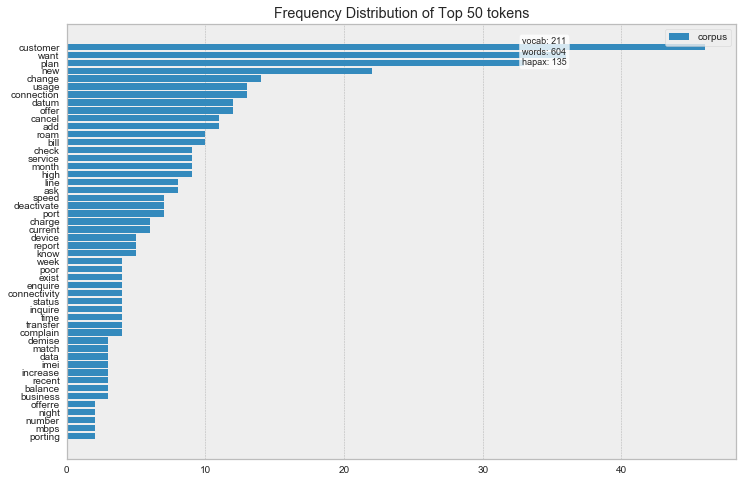

In [25]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df[commentTextColumn])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## Word Distribution Analysis for each Topic

This is very important step in analyzing which set of words contribute to each topics. This gives us an idea about how different models would perform and helps us improve the previous steps. 

In [26]:
def wordFrequency(reasonCode):
    return (df[df[agentAssignedColumn]==str(reasonCode)][commentTextColumn].str.split(expand=True).stack().value_counts())


def wordFrequencyListPlot(reasonCode, plot = False):
    wordFreqDict = df[df[agentAssignedColumn]==str(reasonCode)][commentTextColumn].str.split(expand=True).stack().value_counts().to_dict()
    wordFreqDictMostCommon = dict(collections.Counter(wordFreqDict).most_common(10)) #Considering only Top 10 words
    print(list(wordFreqDictMostCommon.keys()))
    if plot == True:
        plt.title(str(reasonCode), fontdict=None, loc='center')
        plt.bar(wordFreqDictMostCommon.keys(), wordFreqDictMostCommon.values(), width = 0.1  , color='b');
        plt.figure(figsize=(10,10))
        plt.show();
    return list(wordFreqDictMostCommon.keys())

High Bill
['bill', 'high', 'month', 'want', 'customer', 'plan', 'complain', 'afford', 'recent', 'expensive']


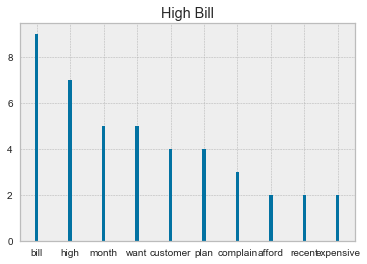

<Figure size 720x720 with 0 Axes>

Change Plans
['plan', 'change', 'offer', 'want', 'new', 'customer', 'current', 'enquire', 'recent', 'hour']


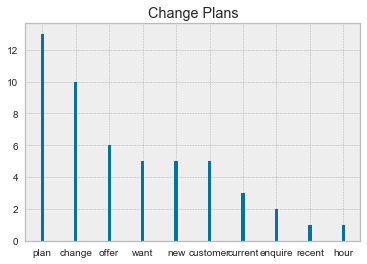

<Figure size 720x720 with 0 Axes>

Add New Line
['new', 'add', 'line', 'want', 'connection', 'customer', 'know', 'offer', 'inquire', 'location']


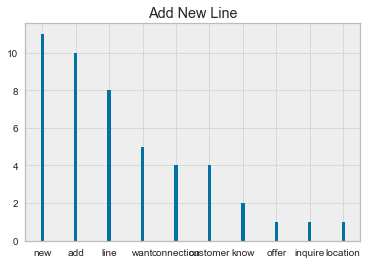

<Figure size 720x720 with 0 Axes>

Deactivate
['deactivate', 'plan', 'customer', 'want', 'offer', 'change', 'current', 'special', 'balance', 'user']


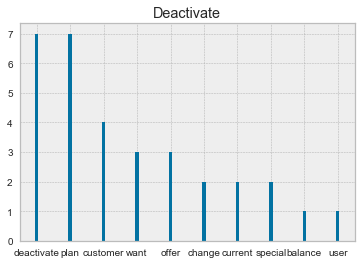

<Figure size 720x720 with 0 Axes>

Others
['want', 'demise', 'imei', 'customer', 'report', 'check', 'particular', 'phone', 'application', 'new']


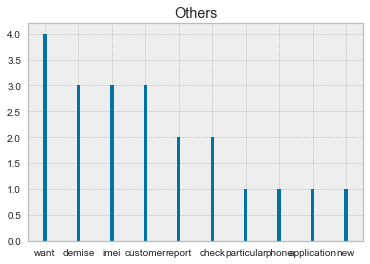

<Figure size 720x720 with 0 Axes>

Roaming Plans
['roam', 'charge', 'customer', 'plan', 'want', 'inquire', 'check', 'month', 'travel', 'state']


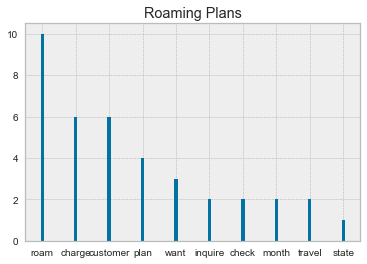

<Figure size 720x720 with 0 Axes>

Poor Connectivity
['speed', 'connection', 'connectivity', 'poor', 'customer', 'report', 'face', 'want', 'low', 'ask']


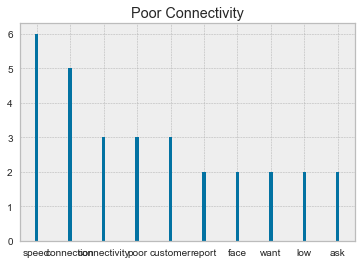

<Figure size 720x720 with 0 Axes>

Port Out
['port', 'customer', 'want', 'transfer', 'ask', 'idea', 'porting', 'bsnl', 'plan', 'option']


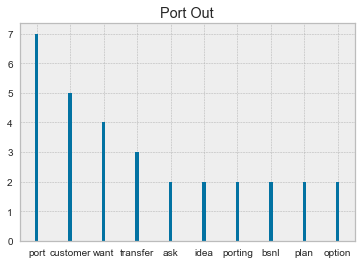

<Figure size 720x720 with 0 Axes>

Cancel Service
['cancel', 'service', 'customer', 'want', 'new', 'exist', 'effect', 'transfer', 'immediate', 'celebration']


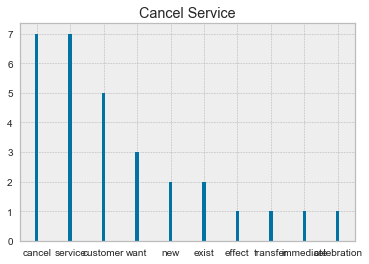

<Figure size 720x720 with 0 Axes>

Data Usage
['usage', 'datum', 'customer', 'data', 'provide', 'month', 'actual', 'statistic', 'check', 'balance']


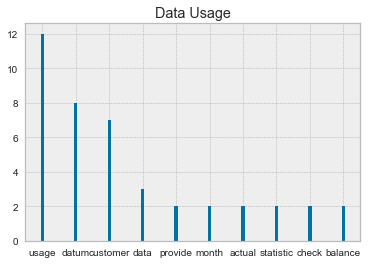

<Figure size 720x720 with 0 Axes>

In [27]:
for reasoncode in uniqueTopics:
    print(reasoncode)
    wordFrequencyListPlot(reasoncode, plot = True)

Generating WordCloud for each reason to have a visual representation of texts corresponding to each topic. We can also have an overall wordcloud.

In [28]:
def wordCloudGenerator(df, reasonCode, save = False):
    dfReasonCodeSubset = df[df[agentAssignedColumn]==reasonCode]
    wordcloud = WordCloud(max_words=50,background_color='white',max_font_size = 50,width=100, height=100).generate(' '.join(dfReasonCodeSubset[commentTextColumn]))
    plt.imshow(wordcloud)
    plt.title(str(reasonCode), fontdict=None, loc='center')
    plt.figure(figsize=(50,50))
    plt.axis("off")
    plt.show();
    if save:
        plt.savefig('wordCloud'+str(reasonCode)+'.png', bbox_inches='tight')
    

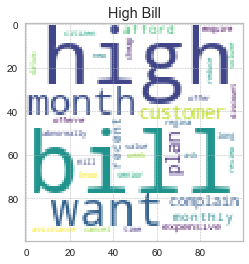

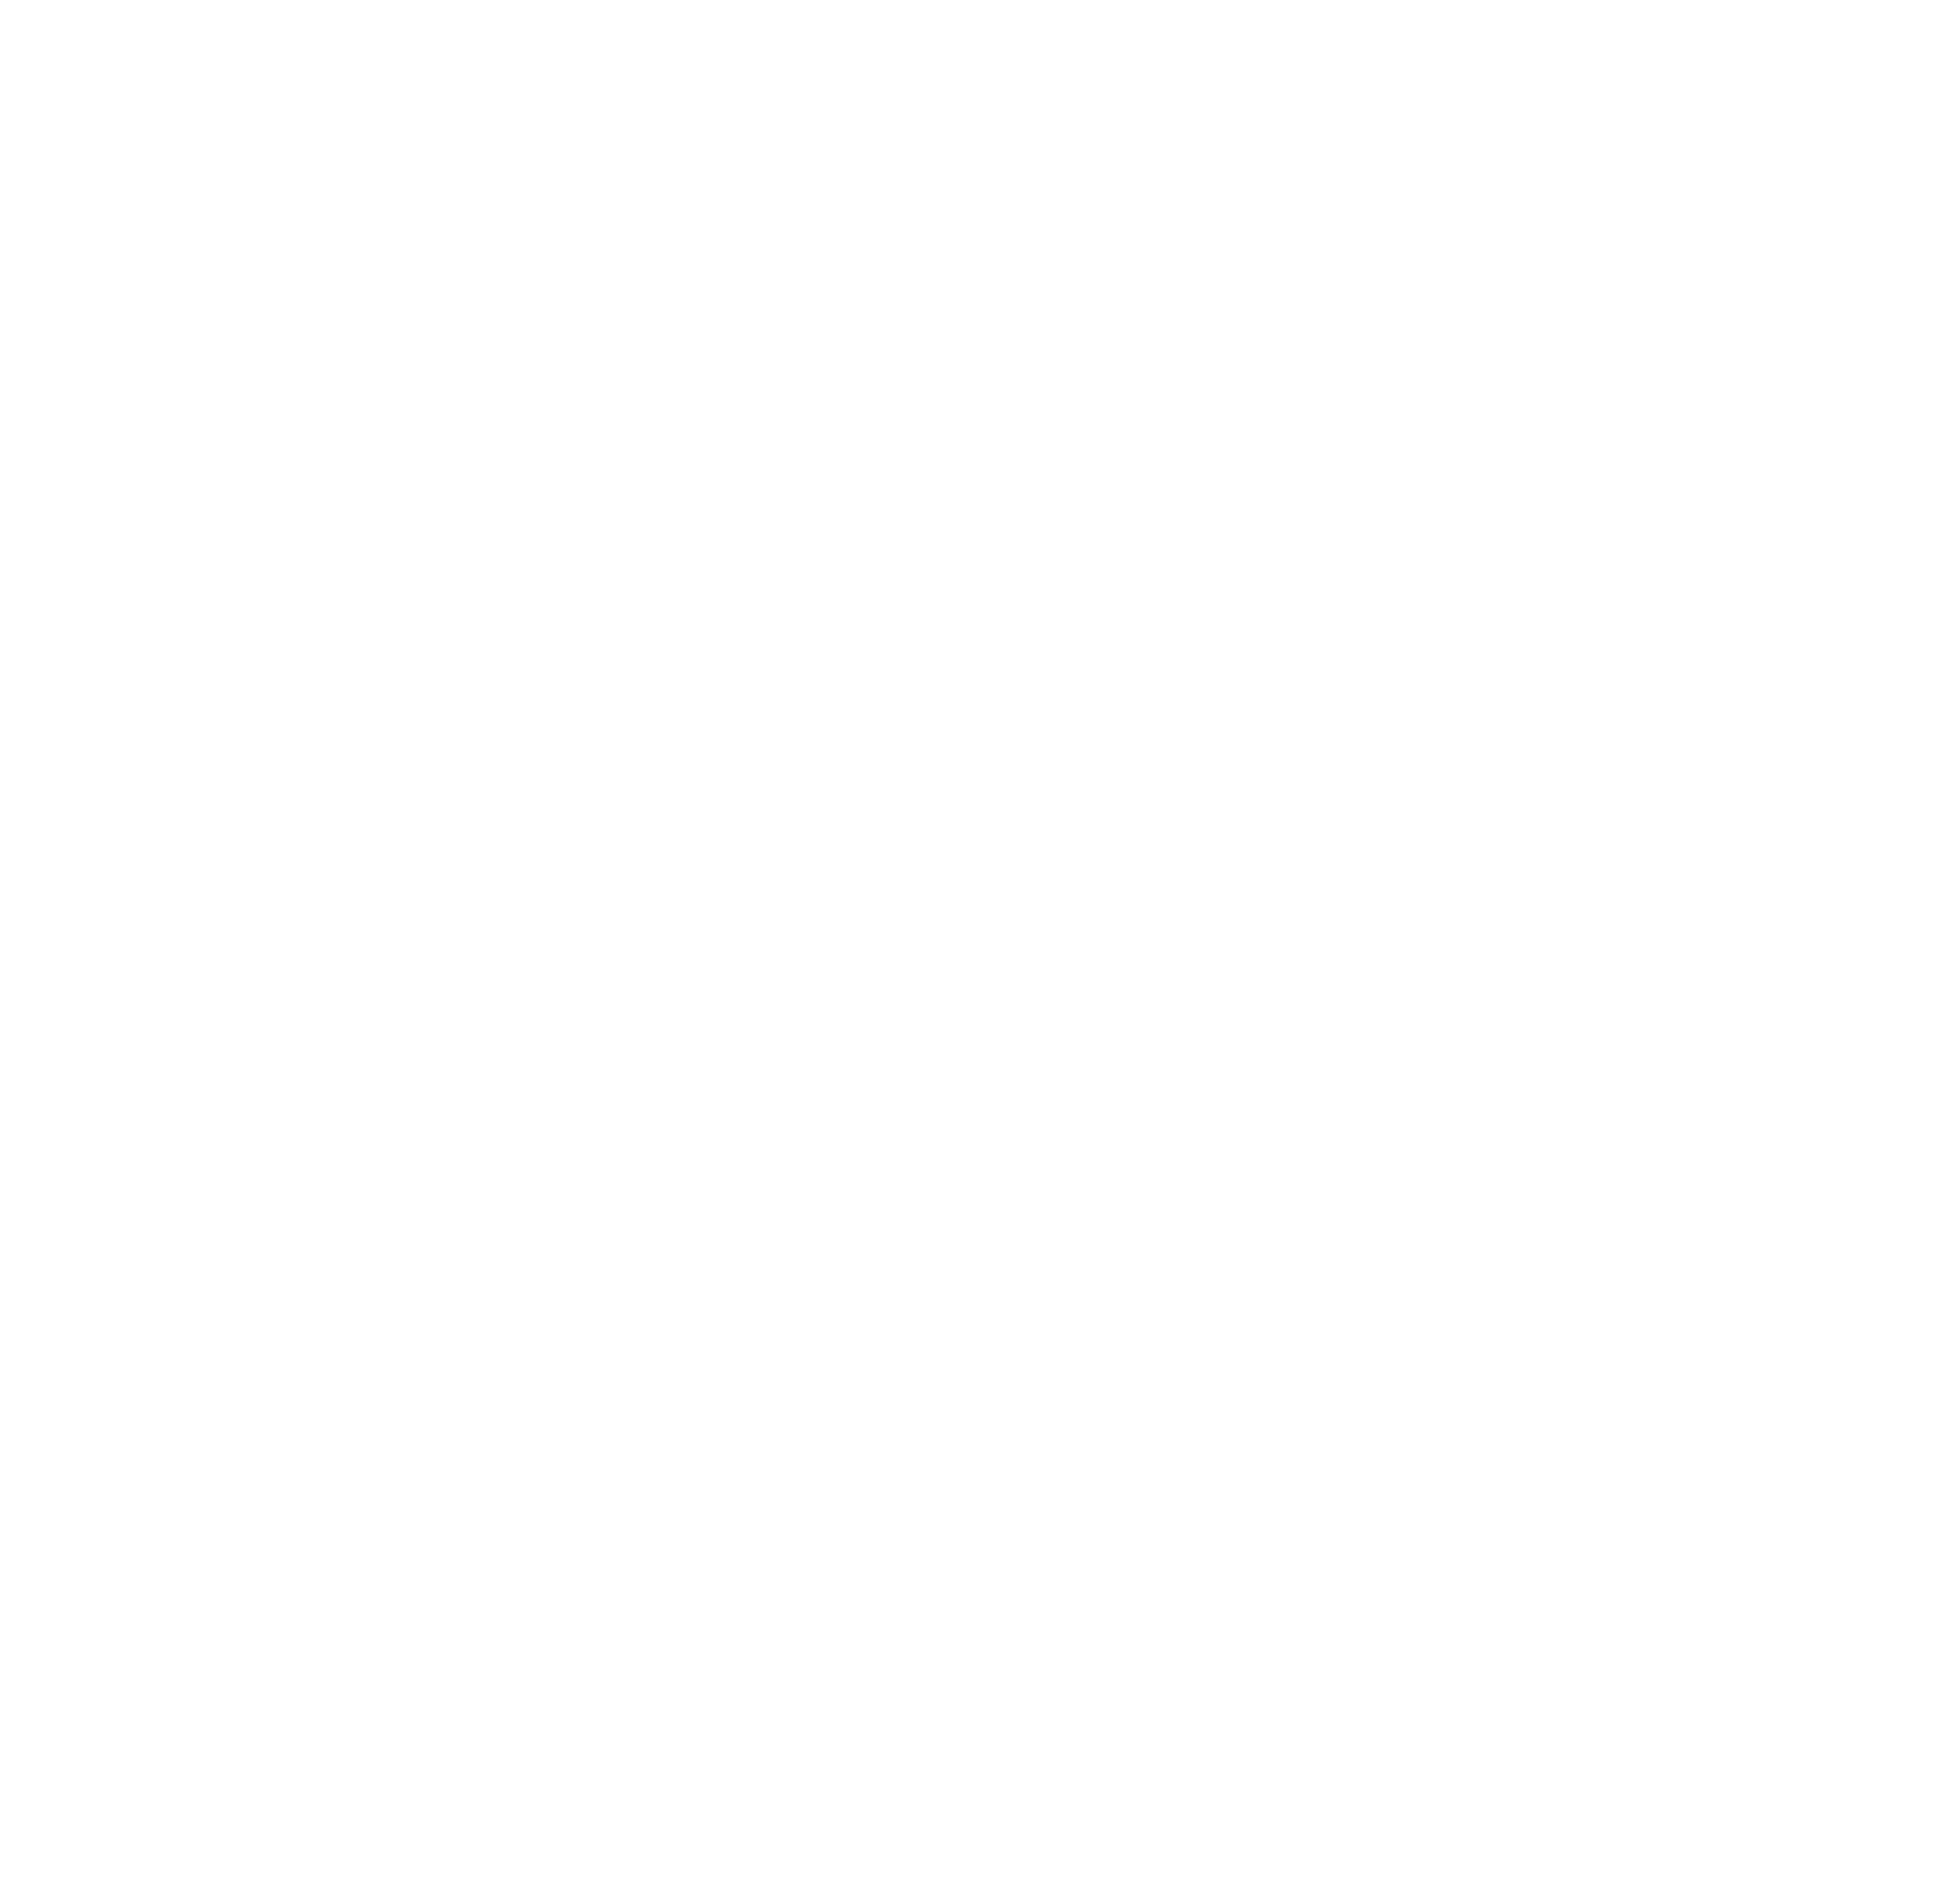

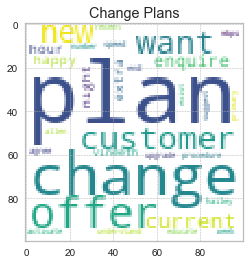

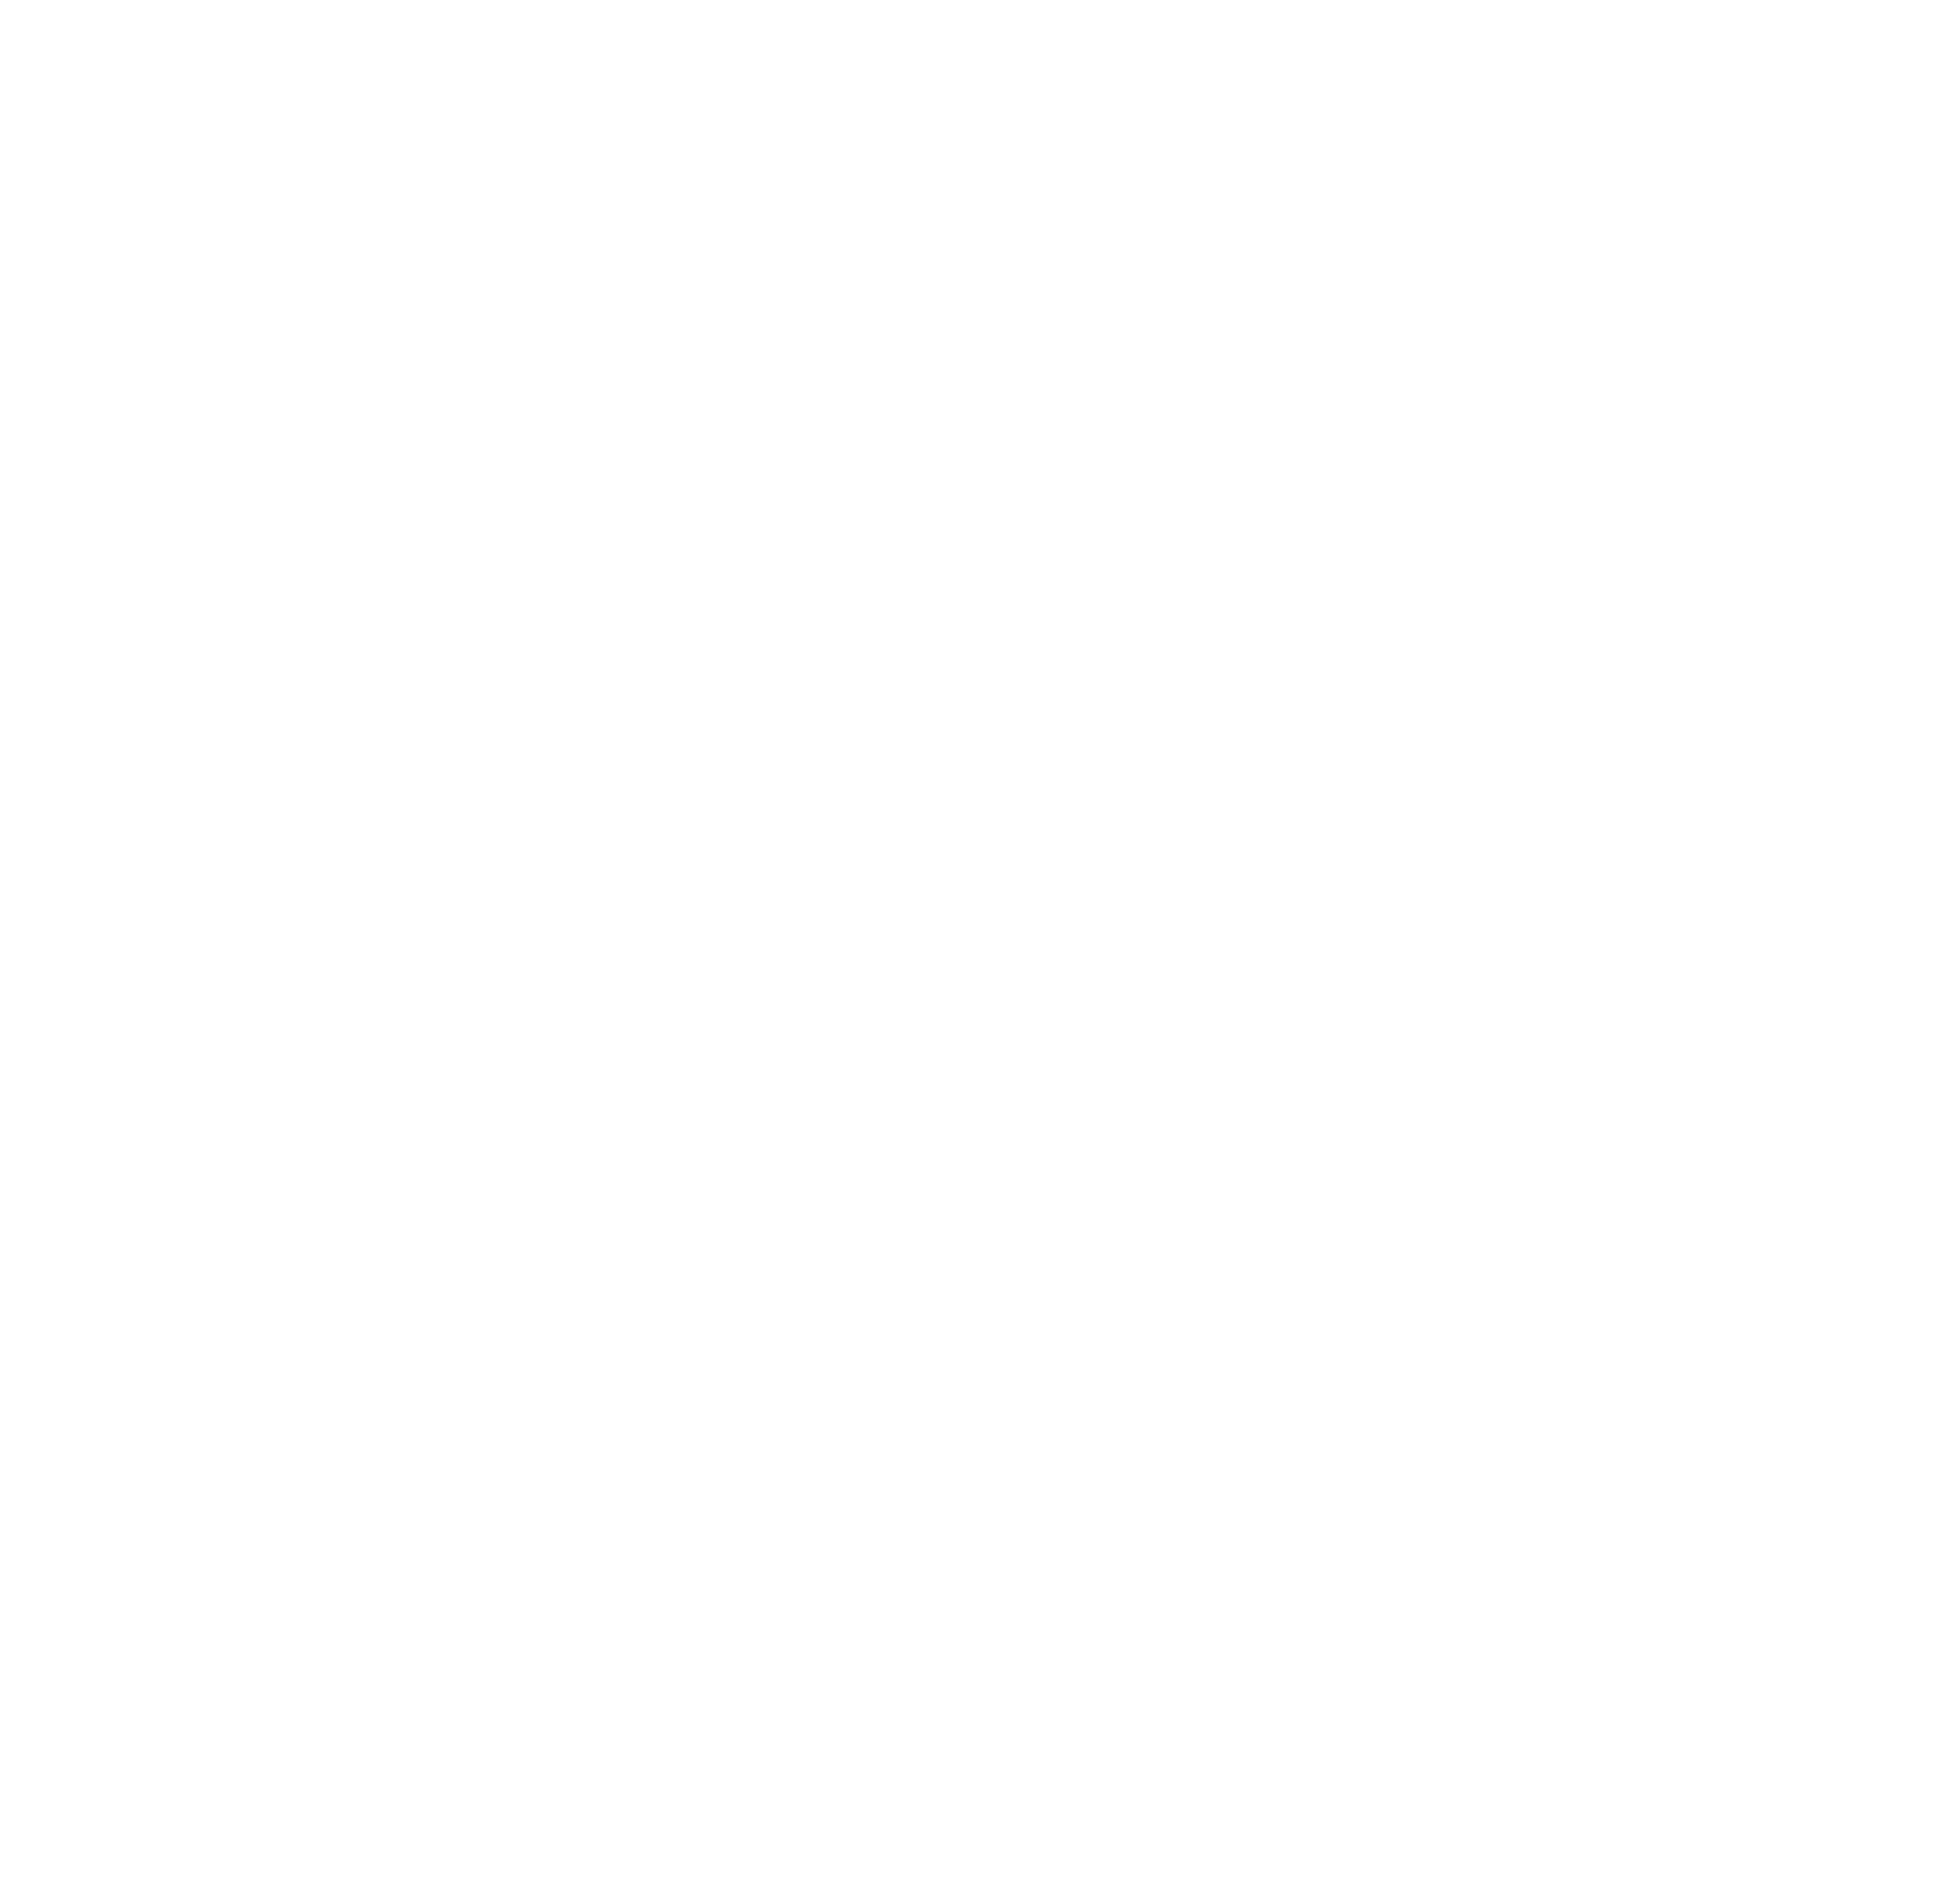

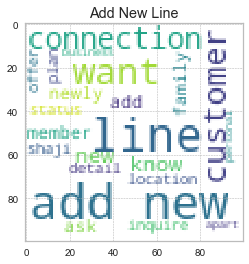

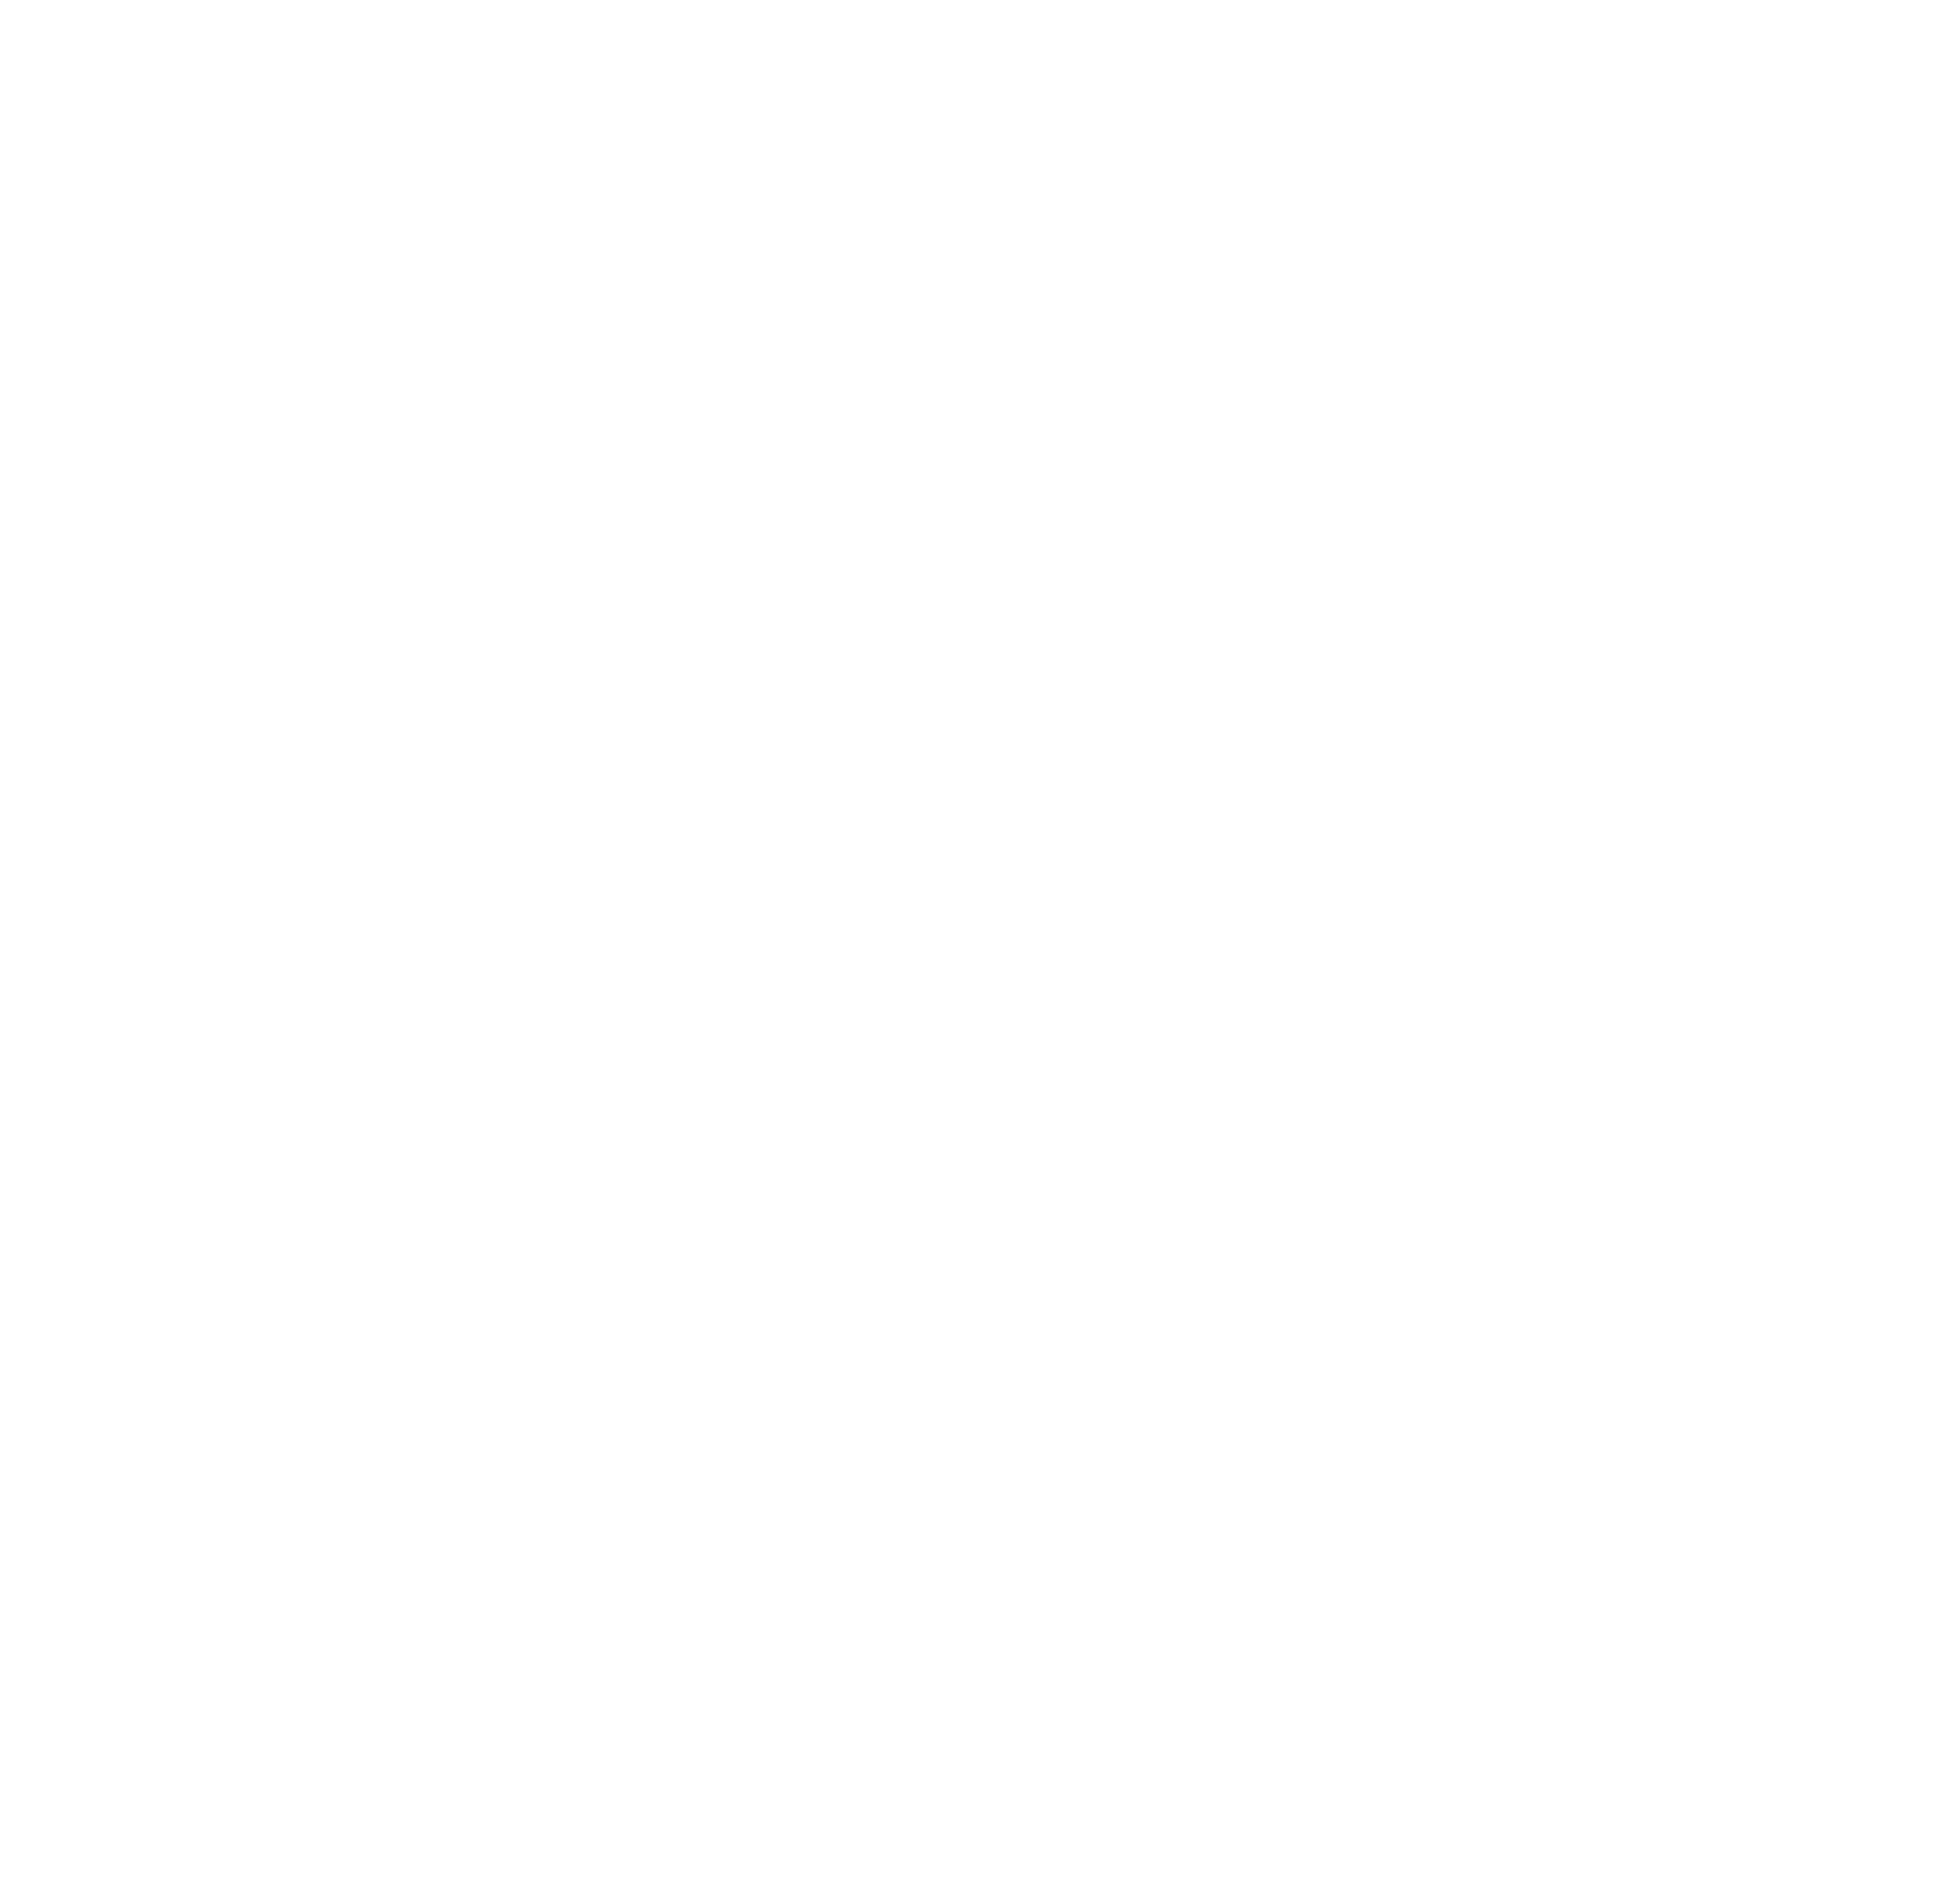

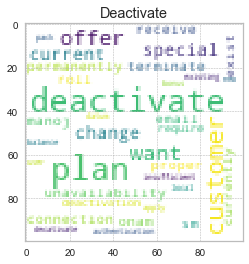

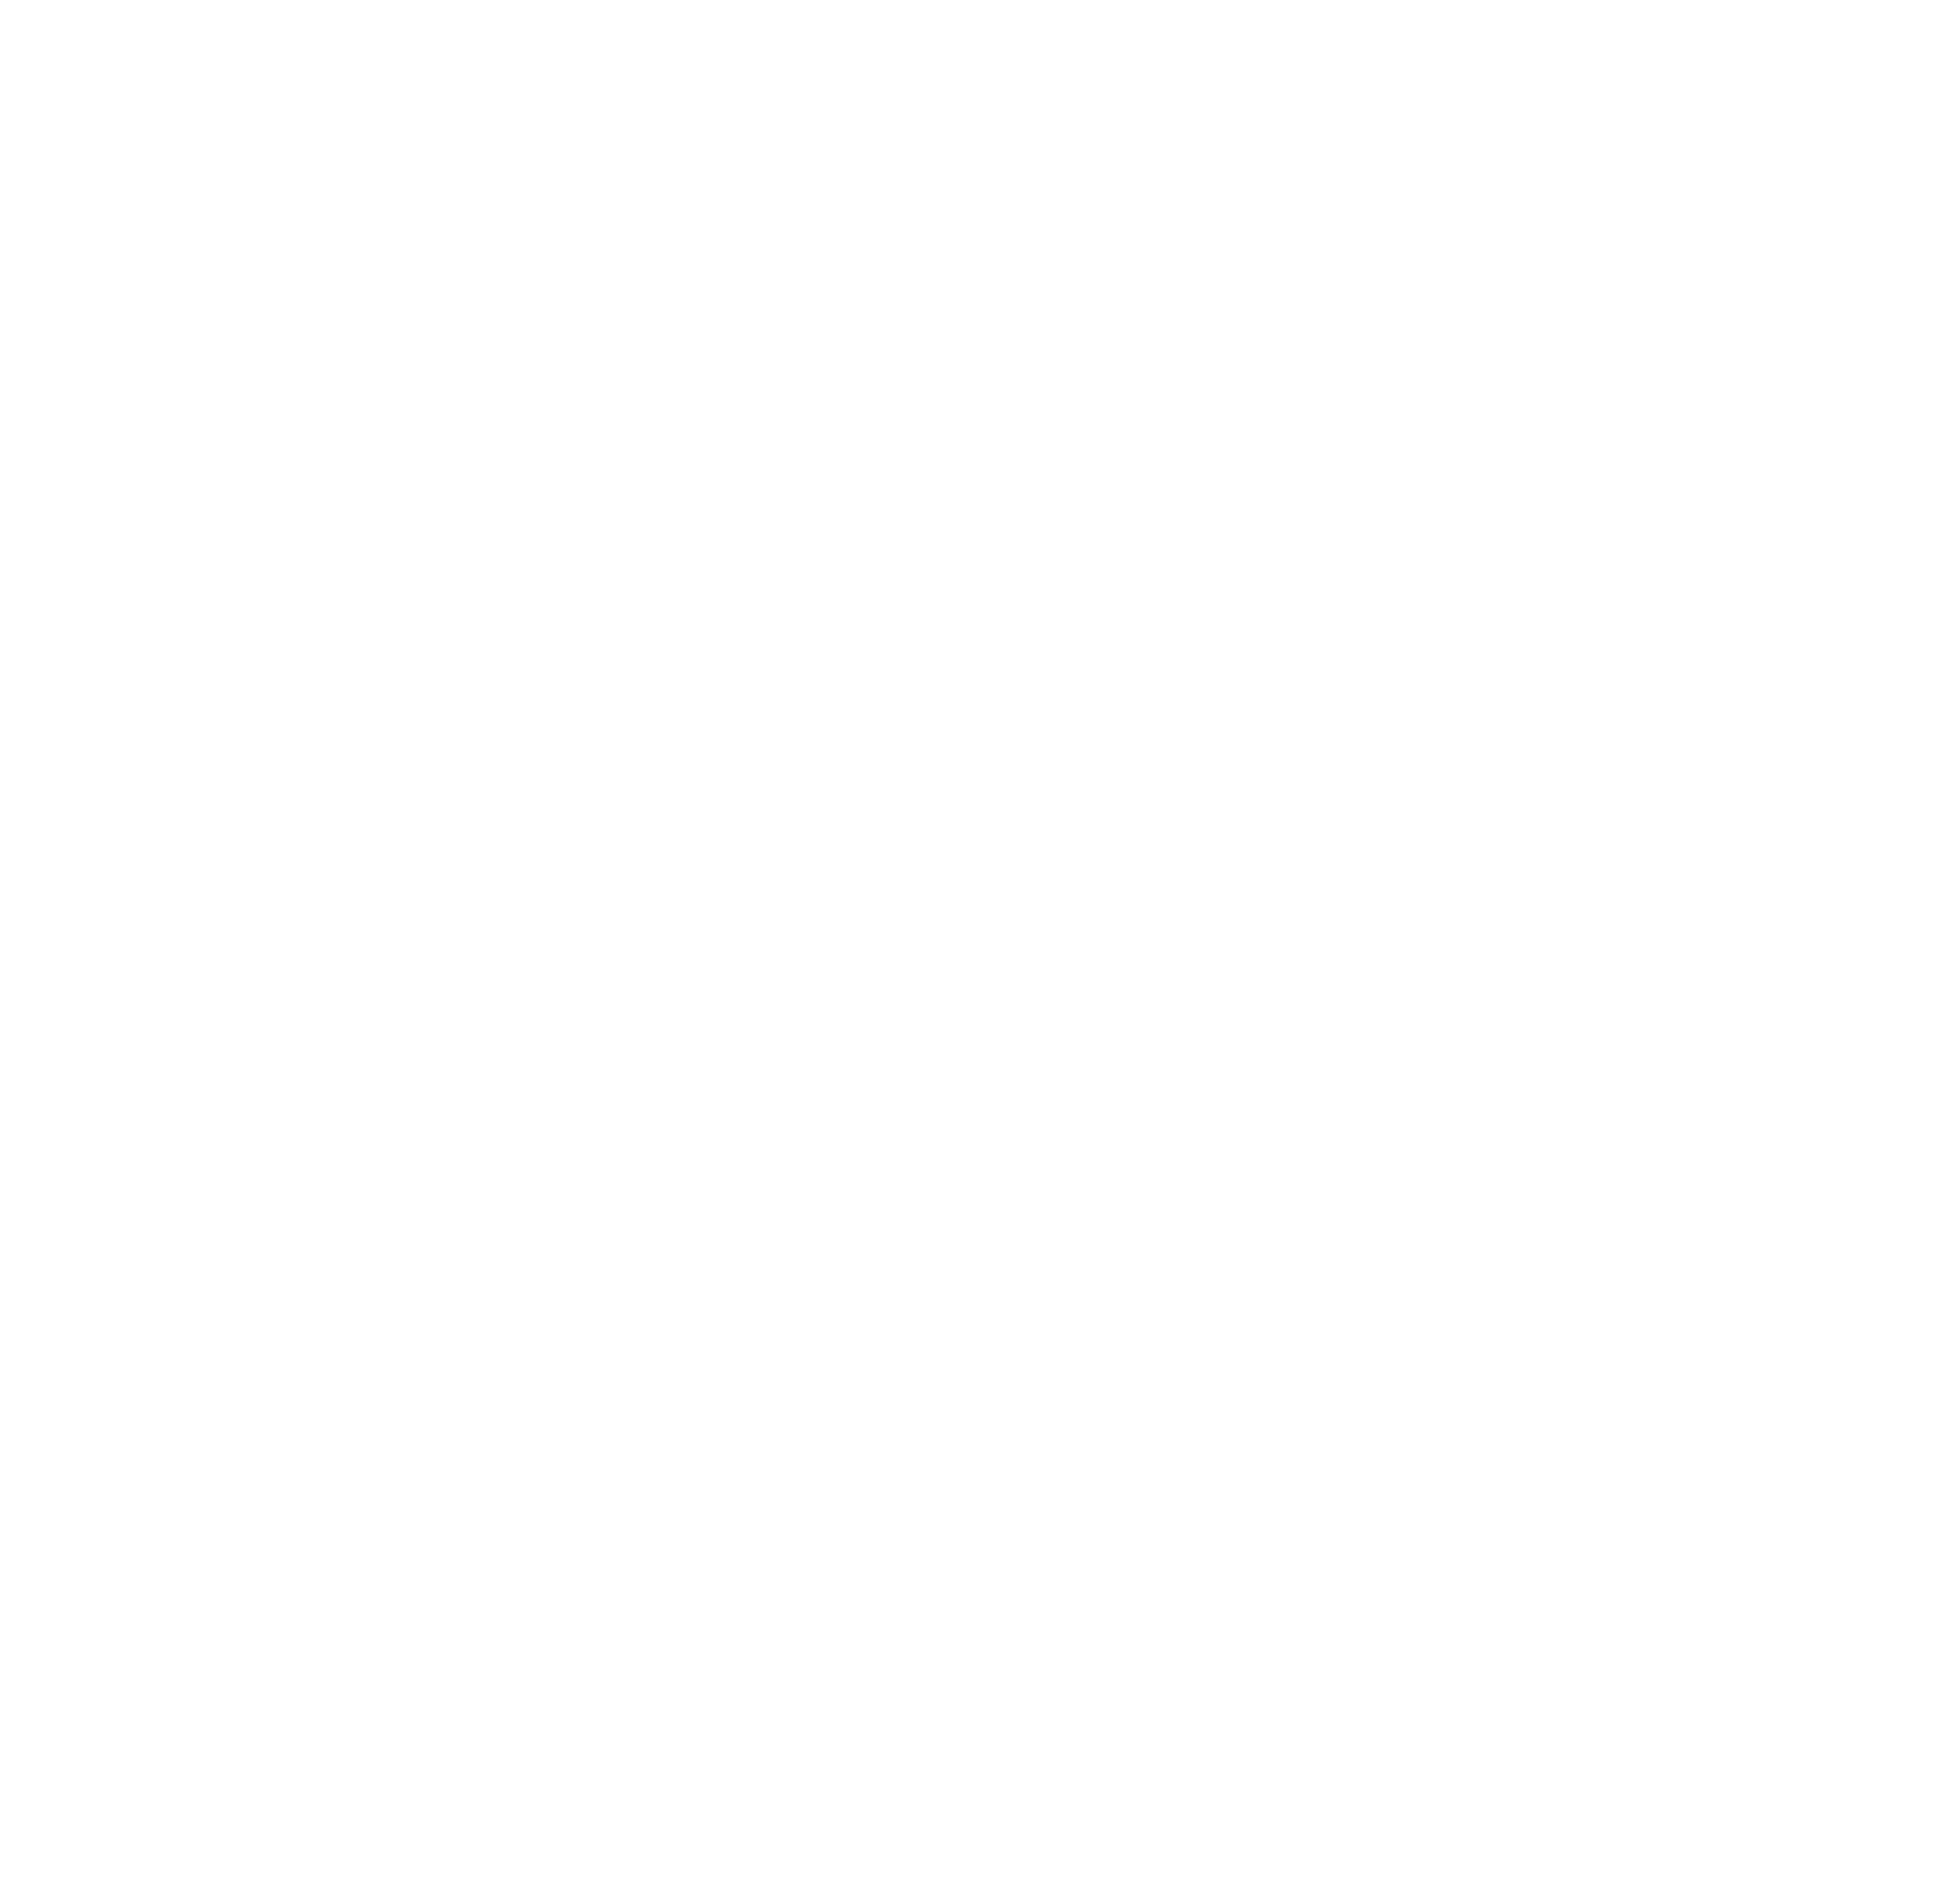

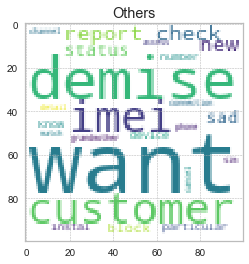

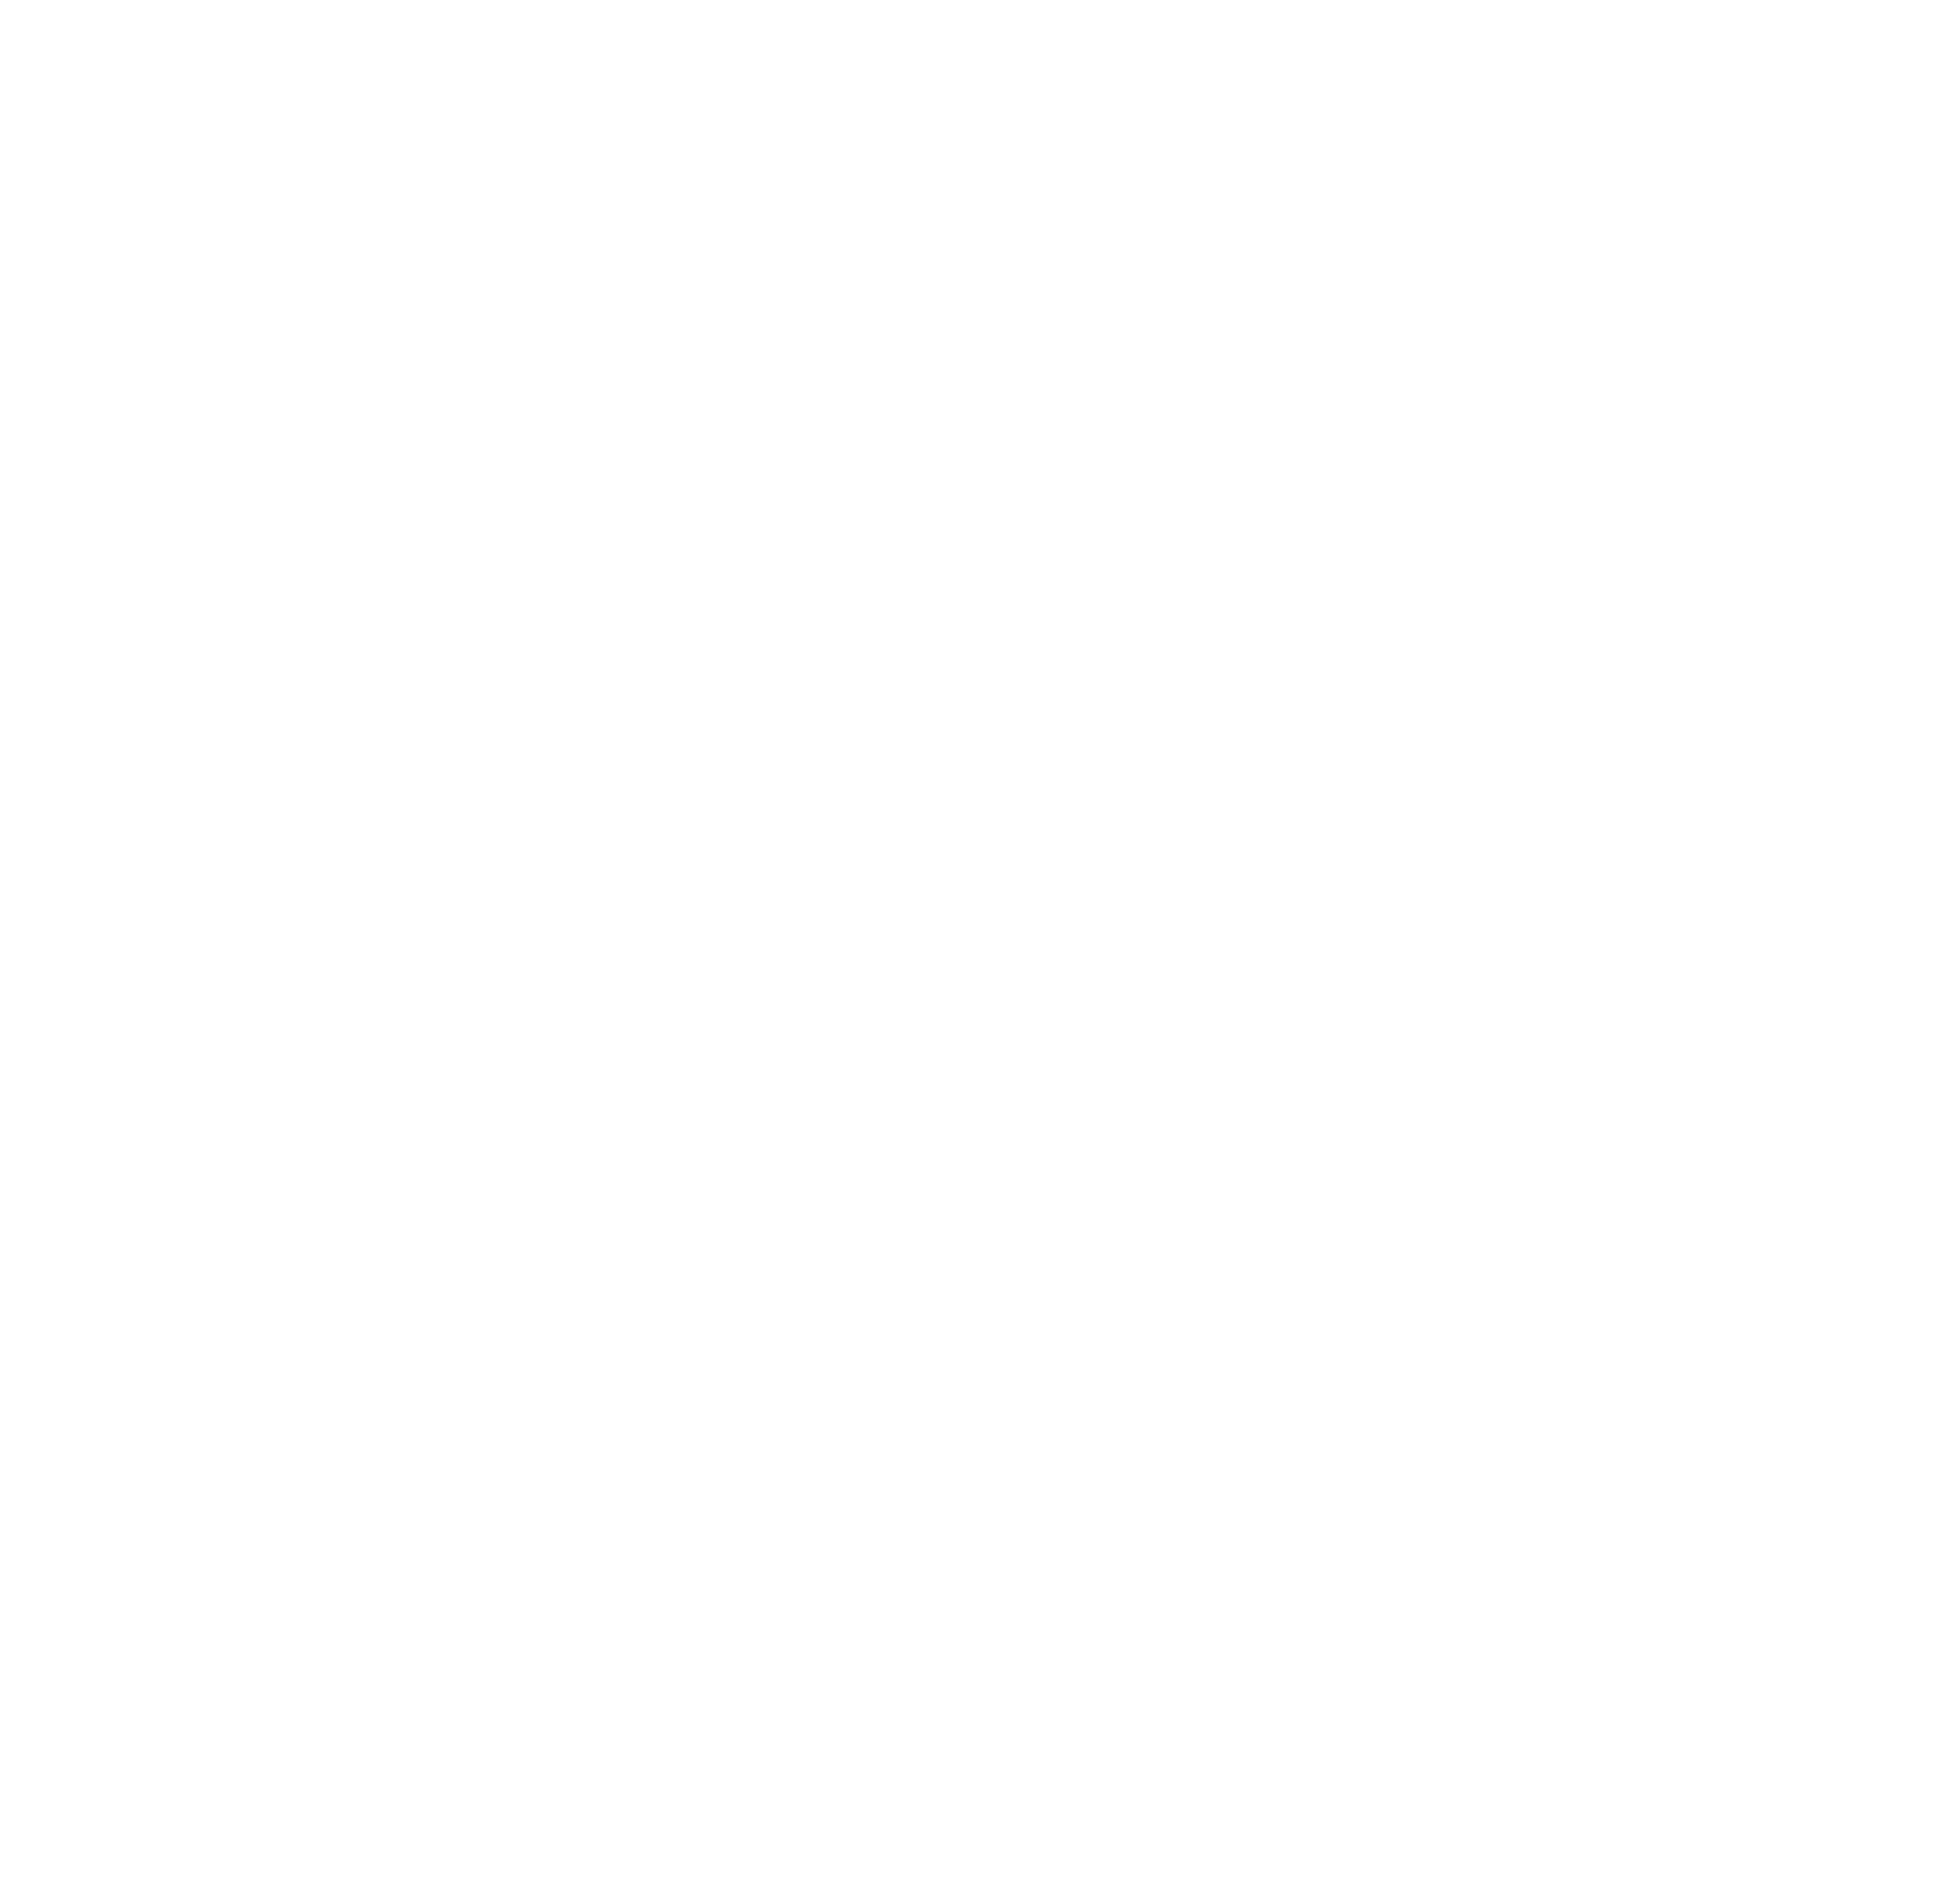

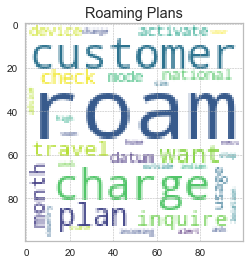

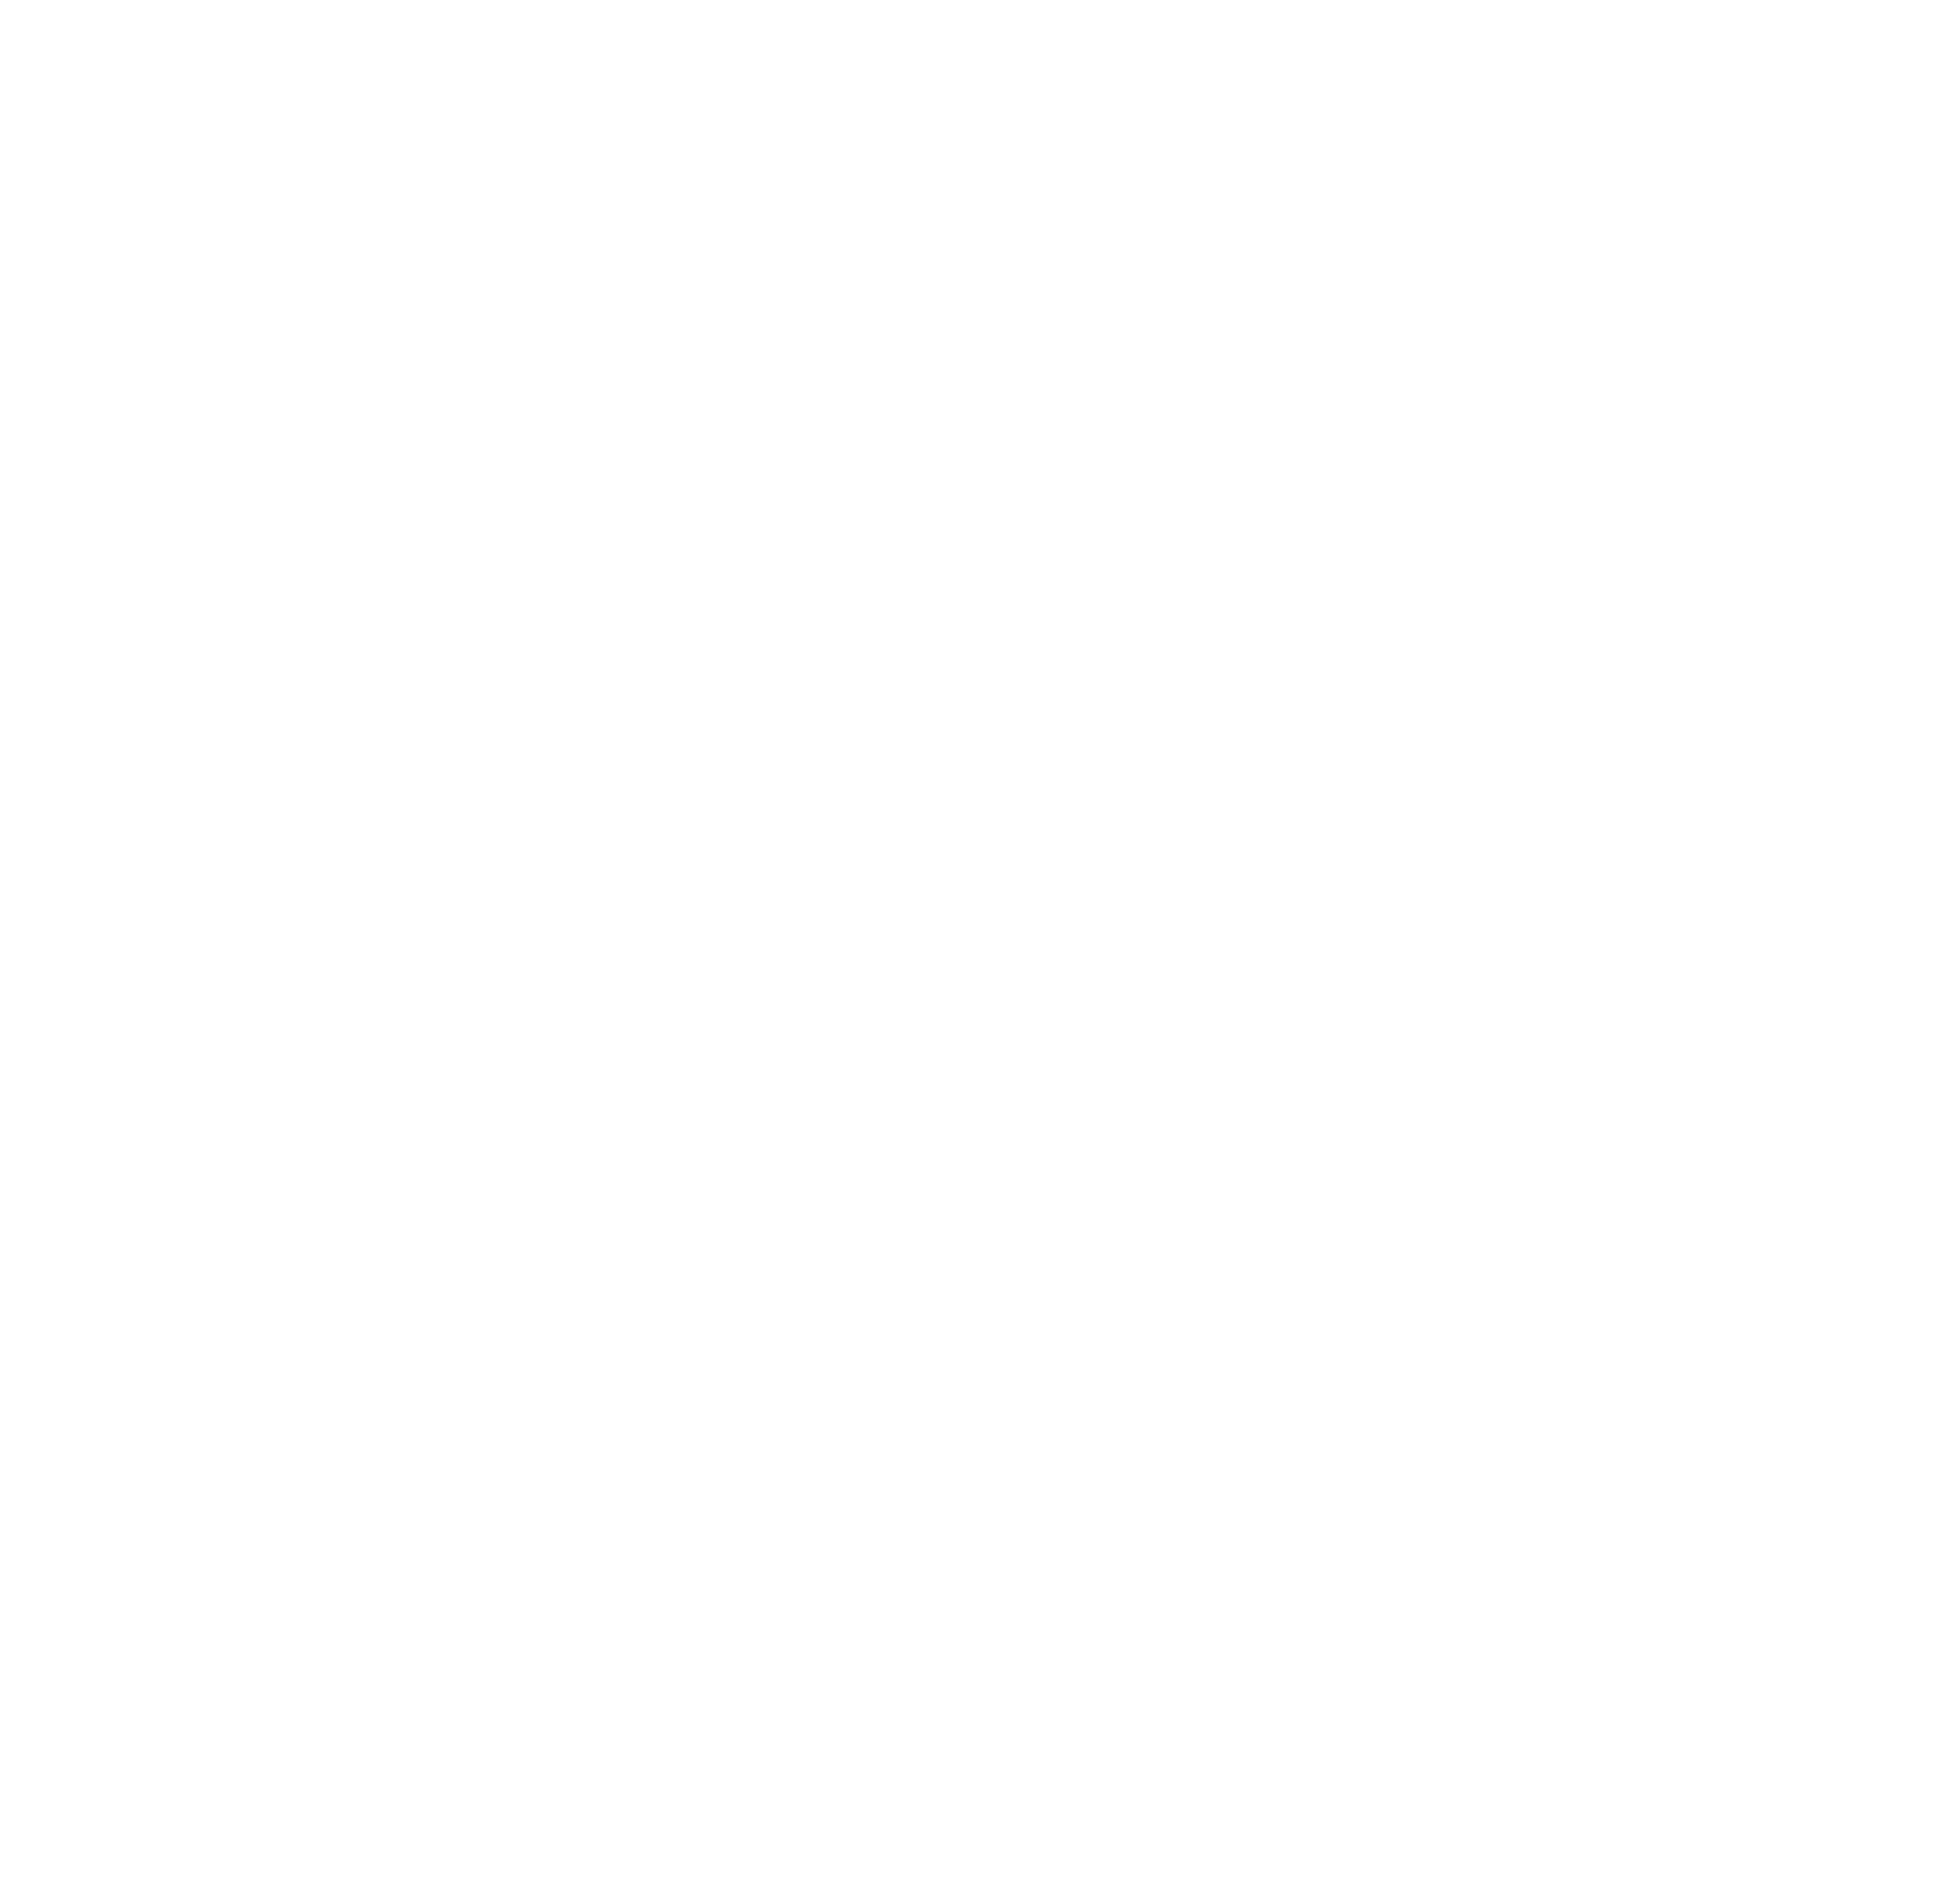

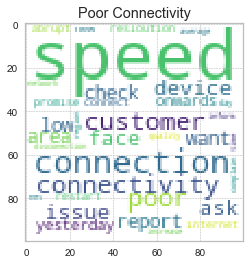

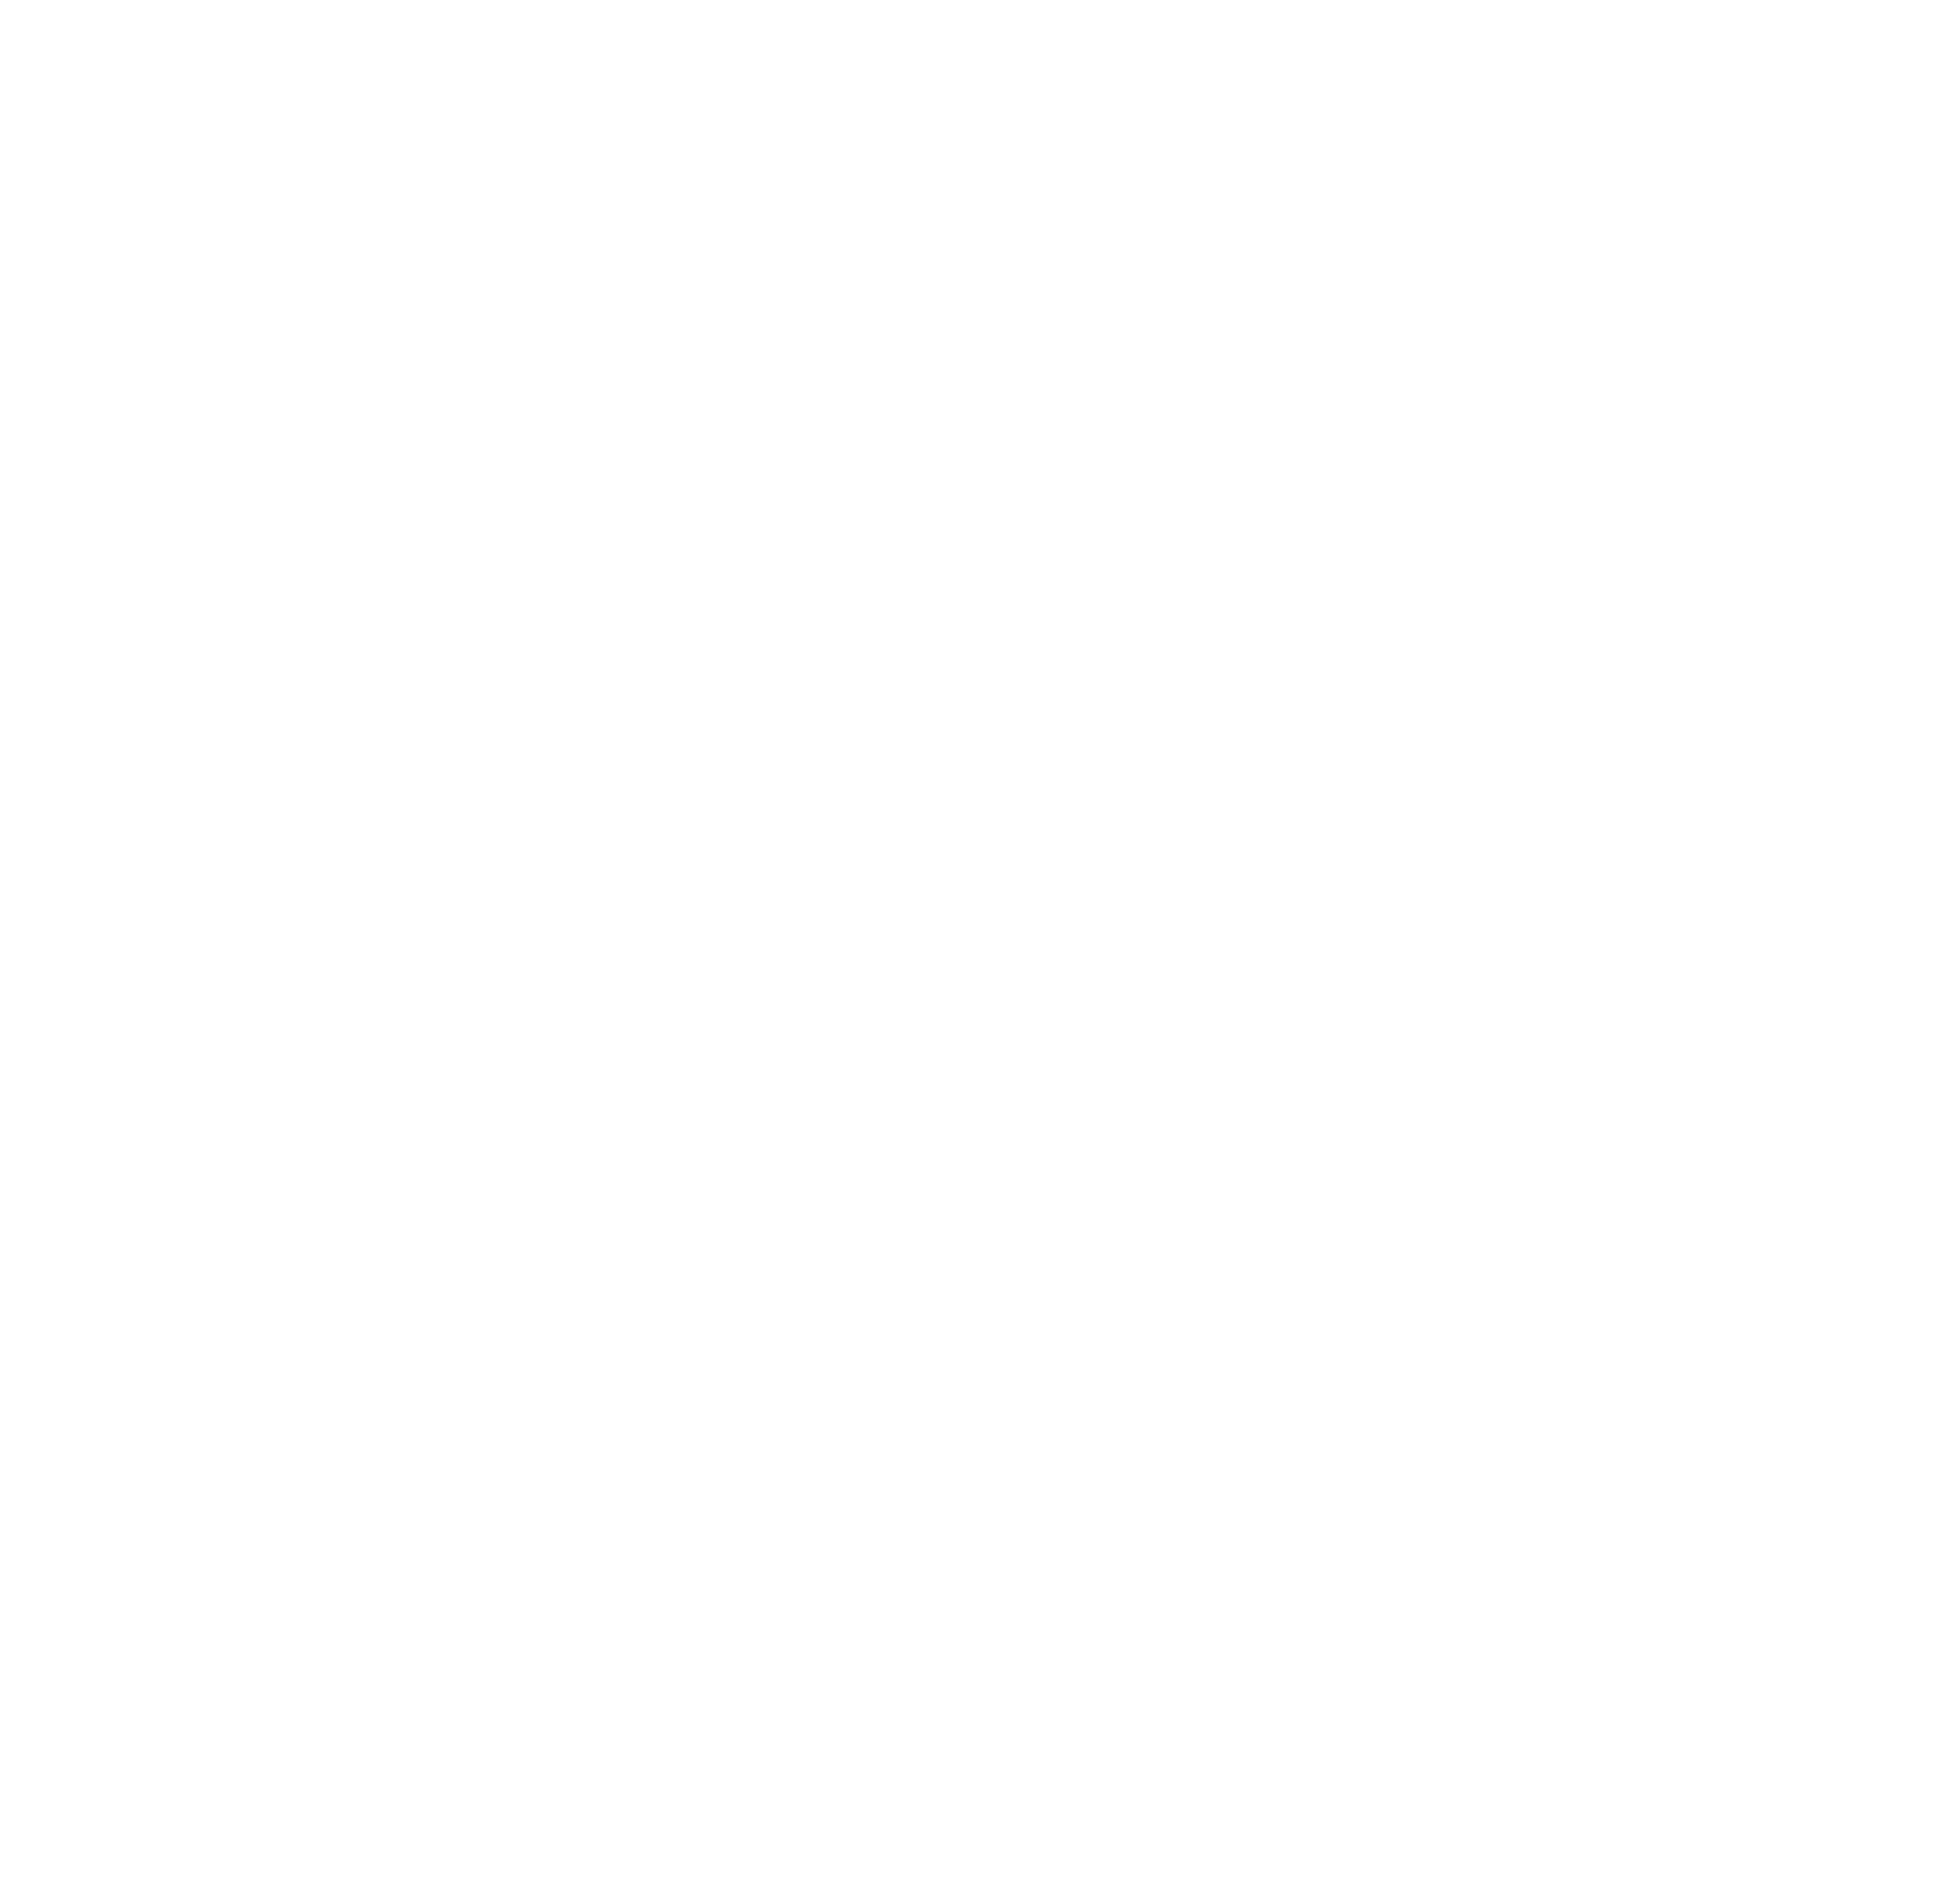

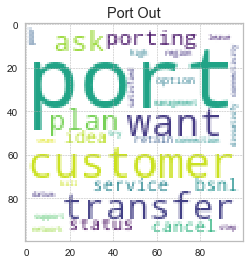

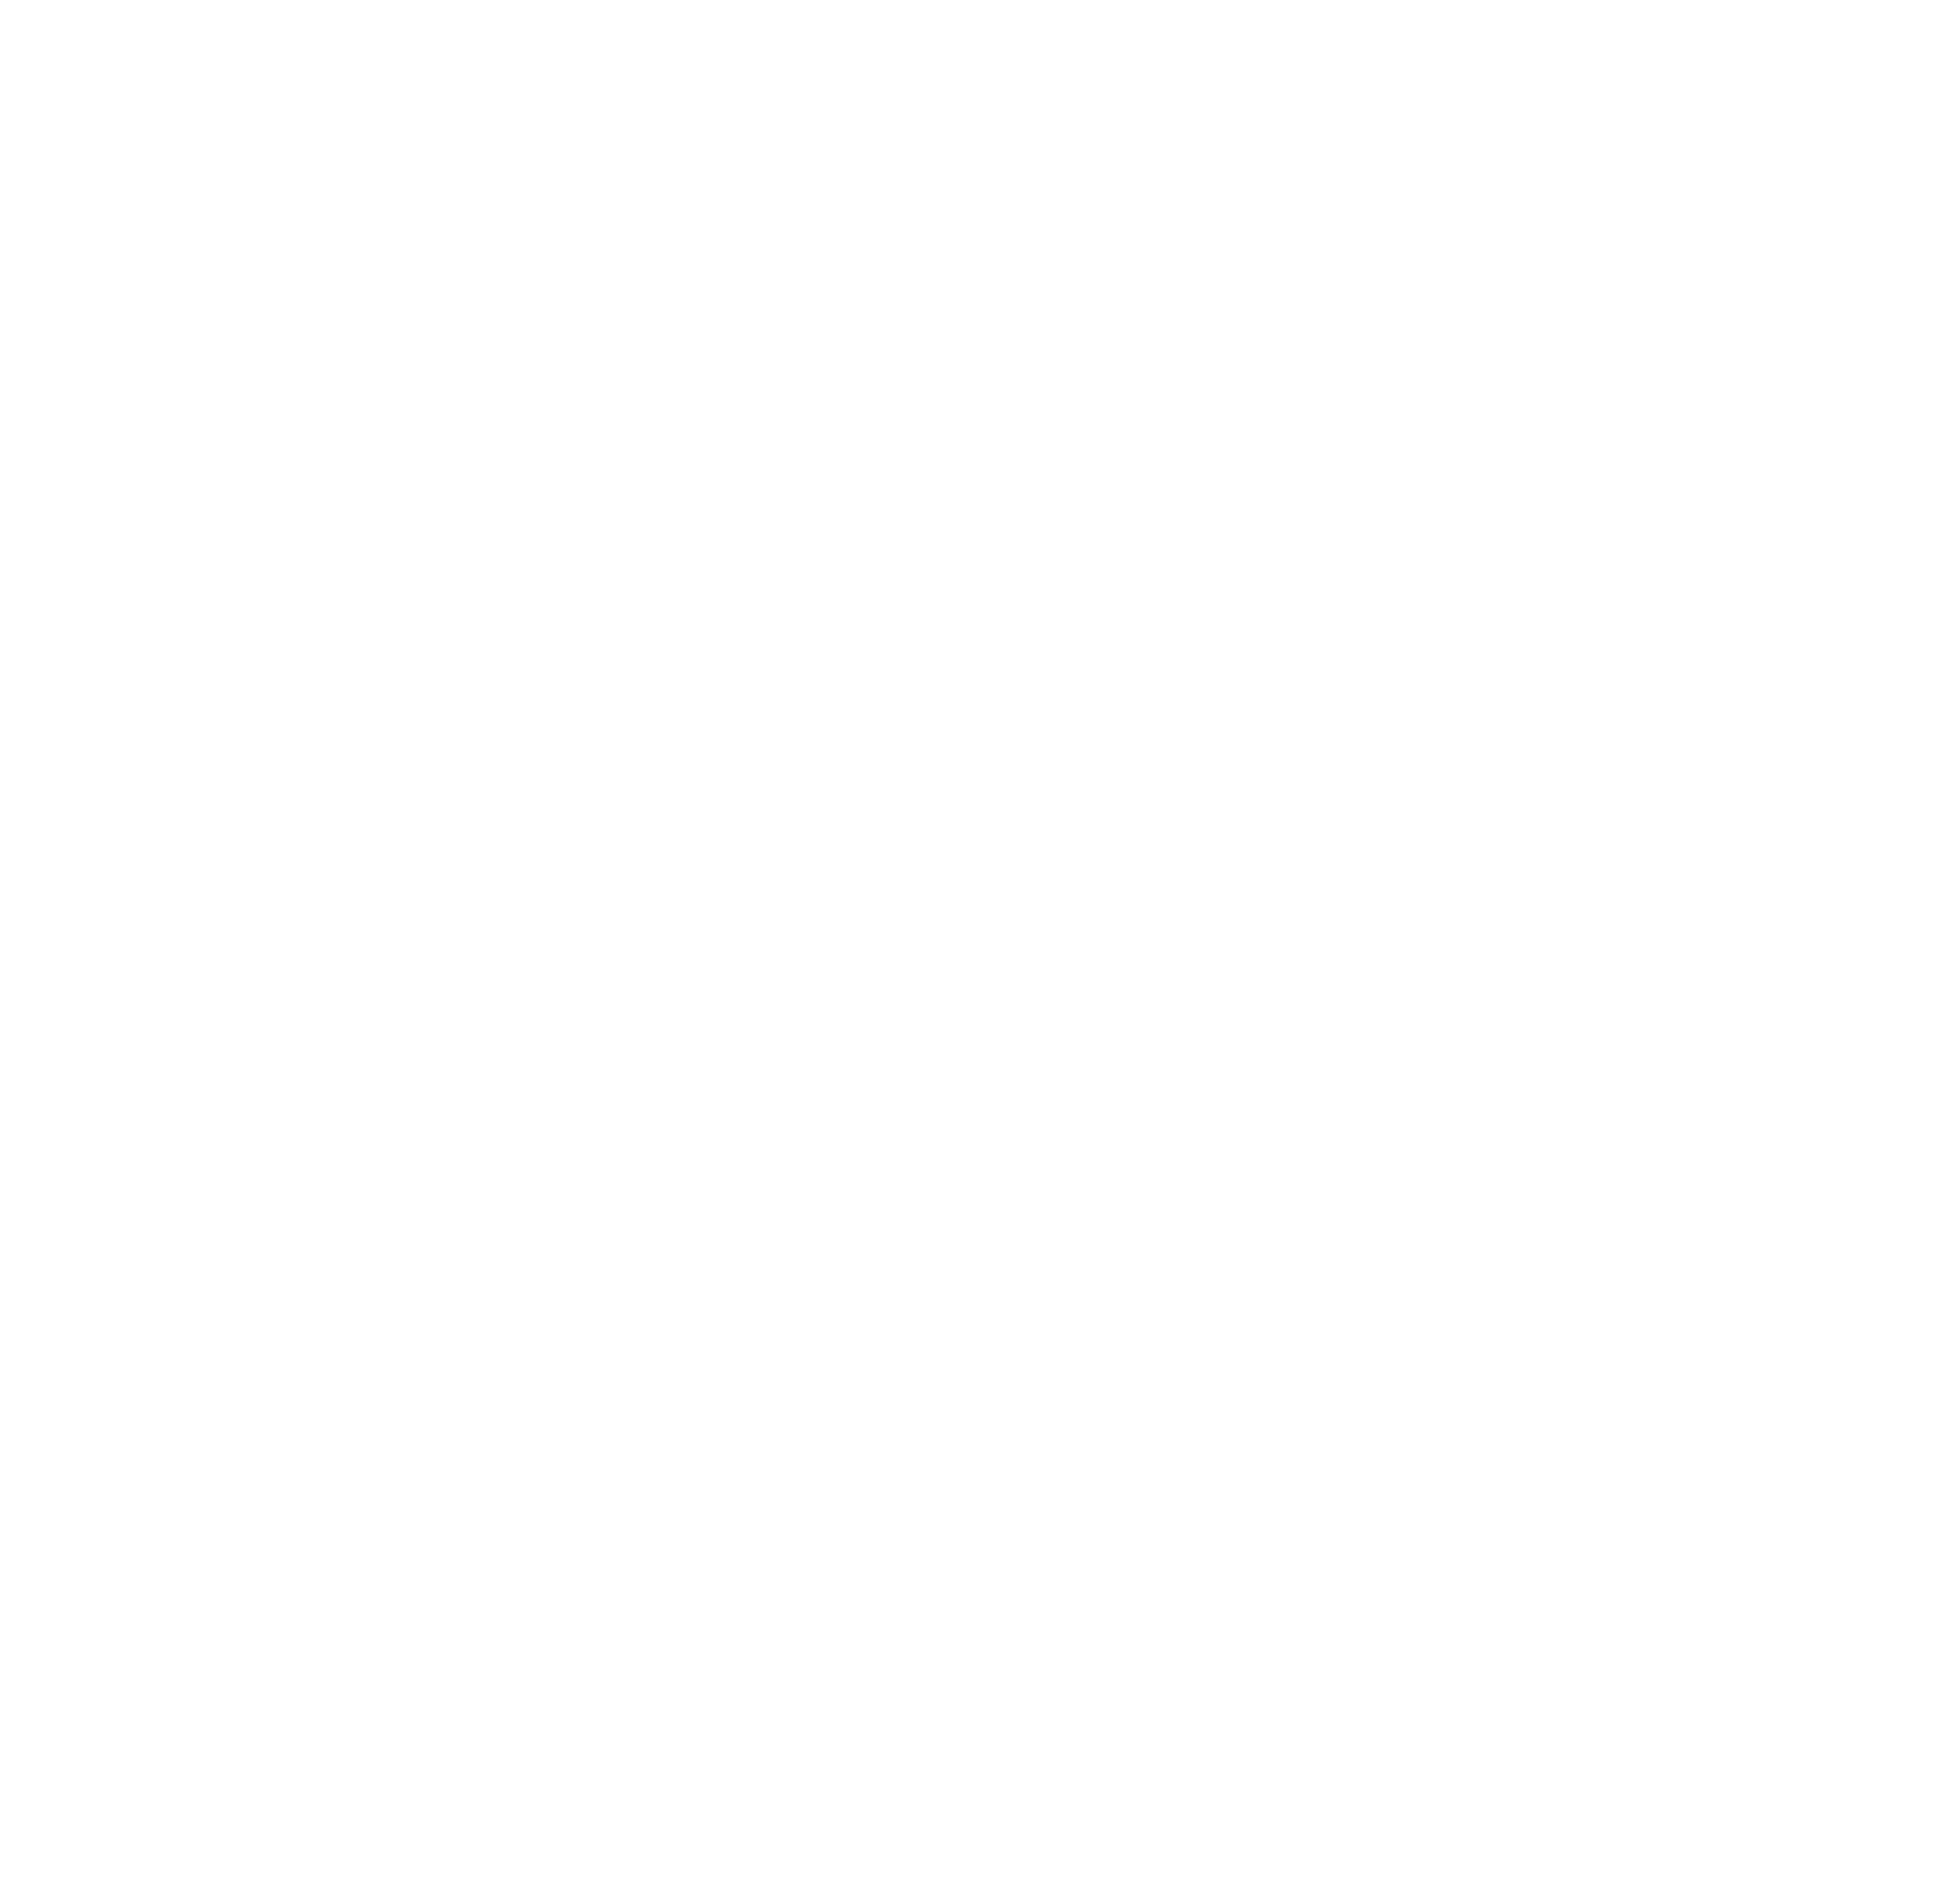

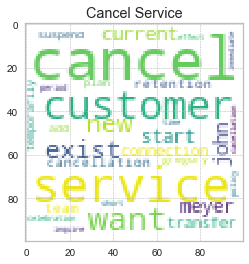

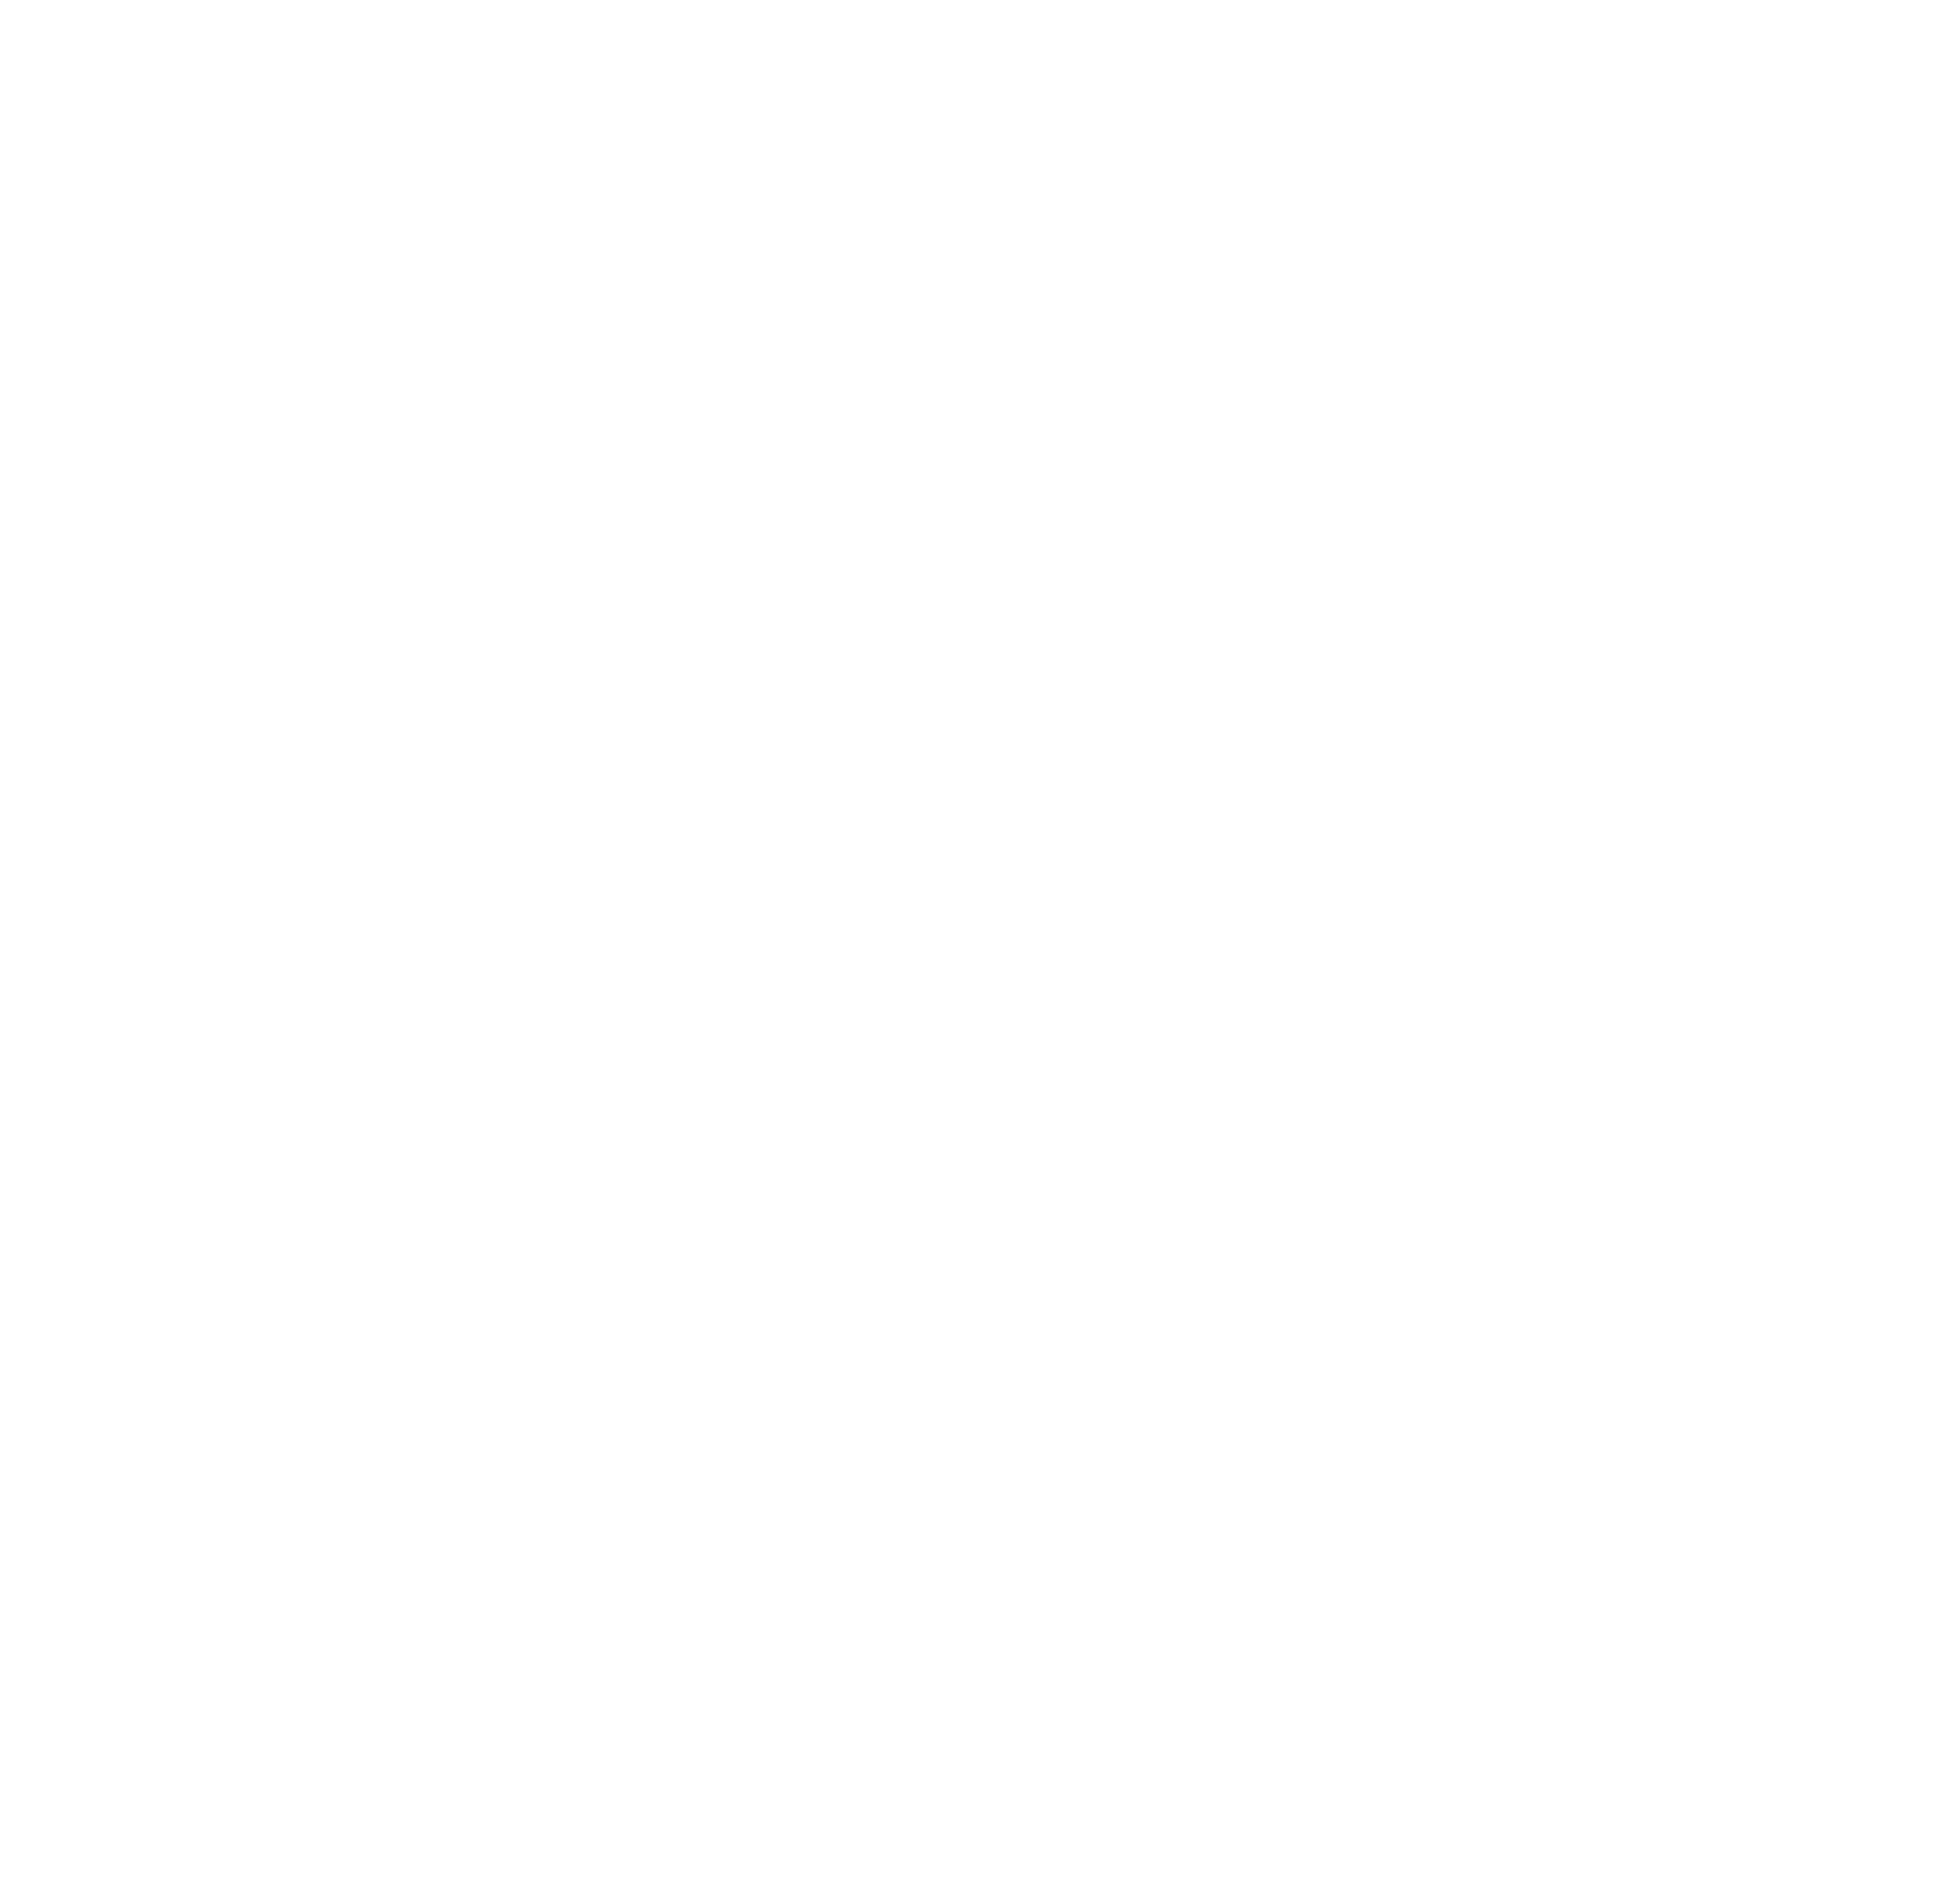

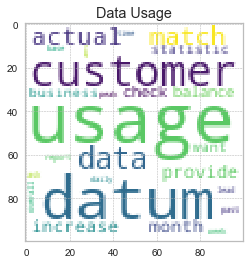

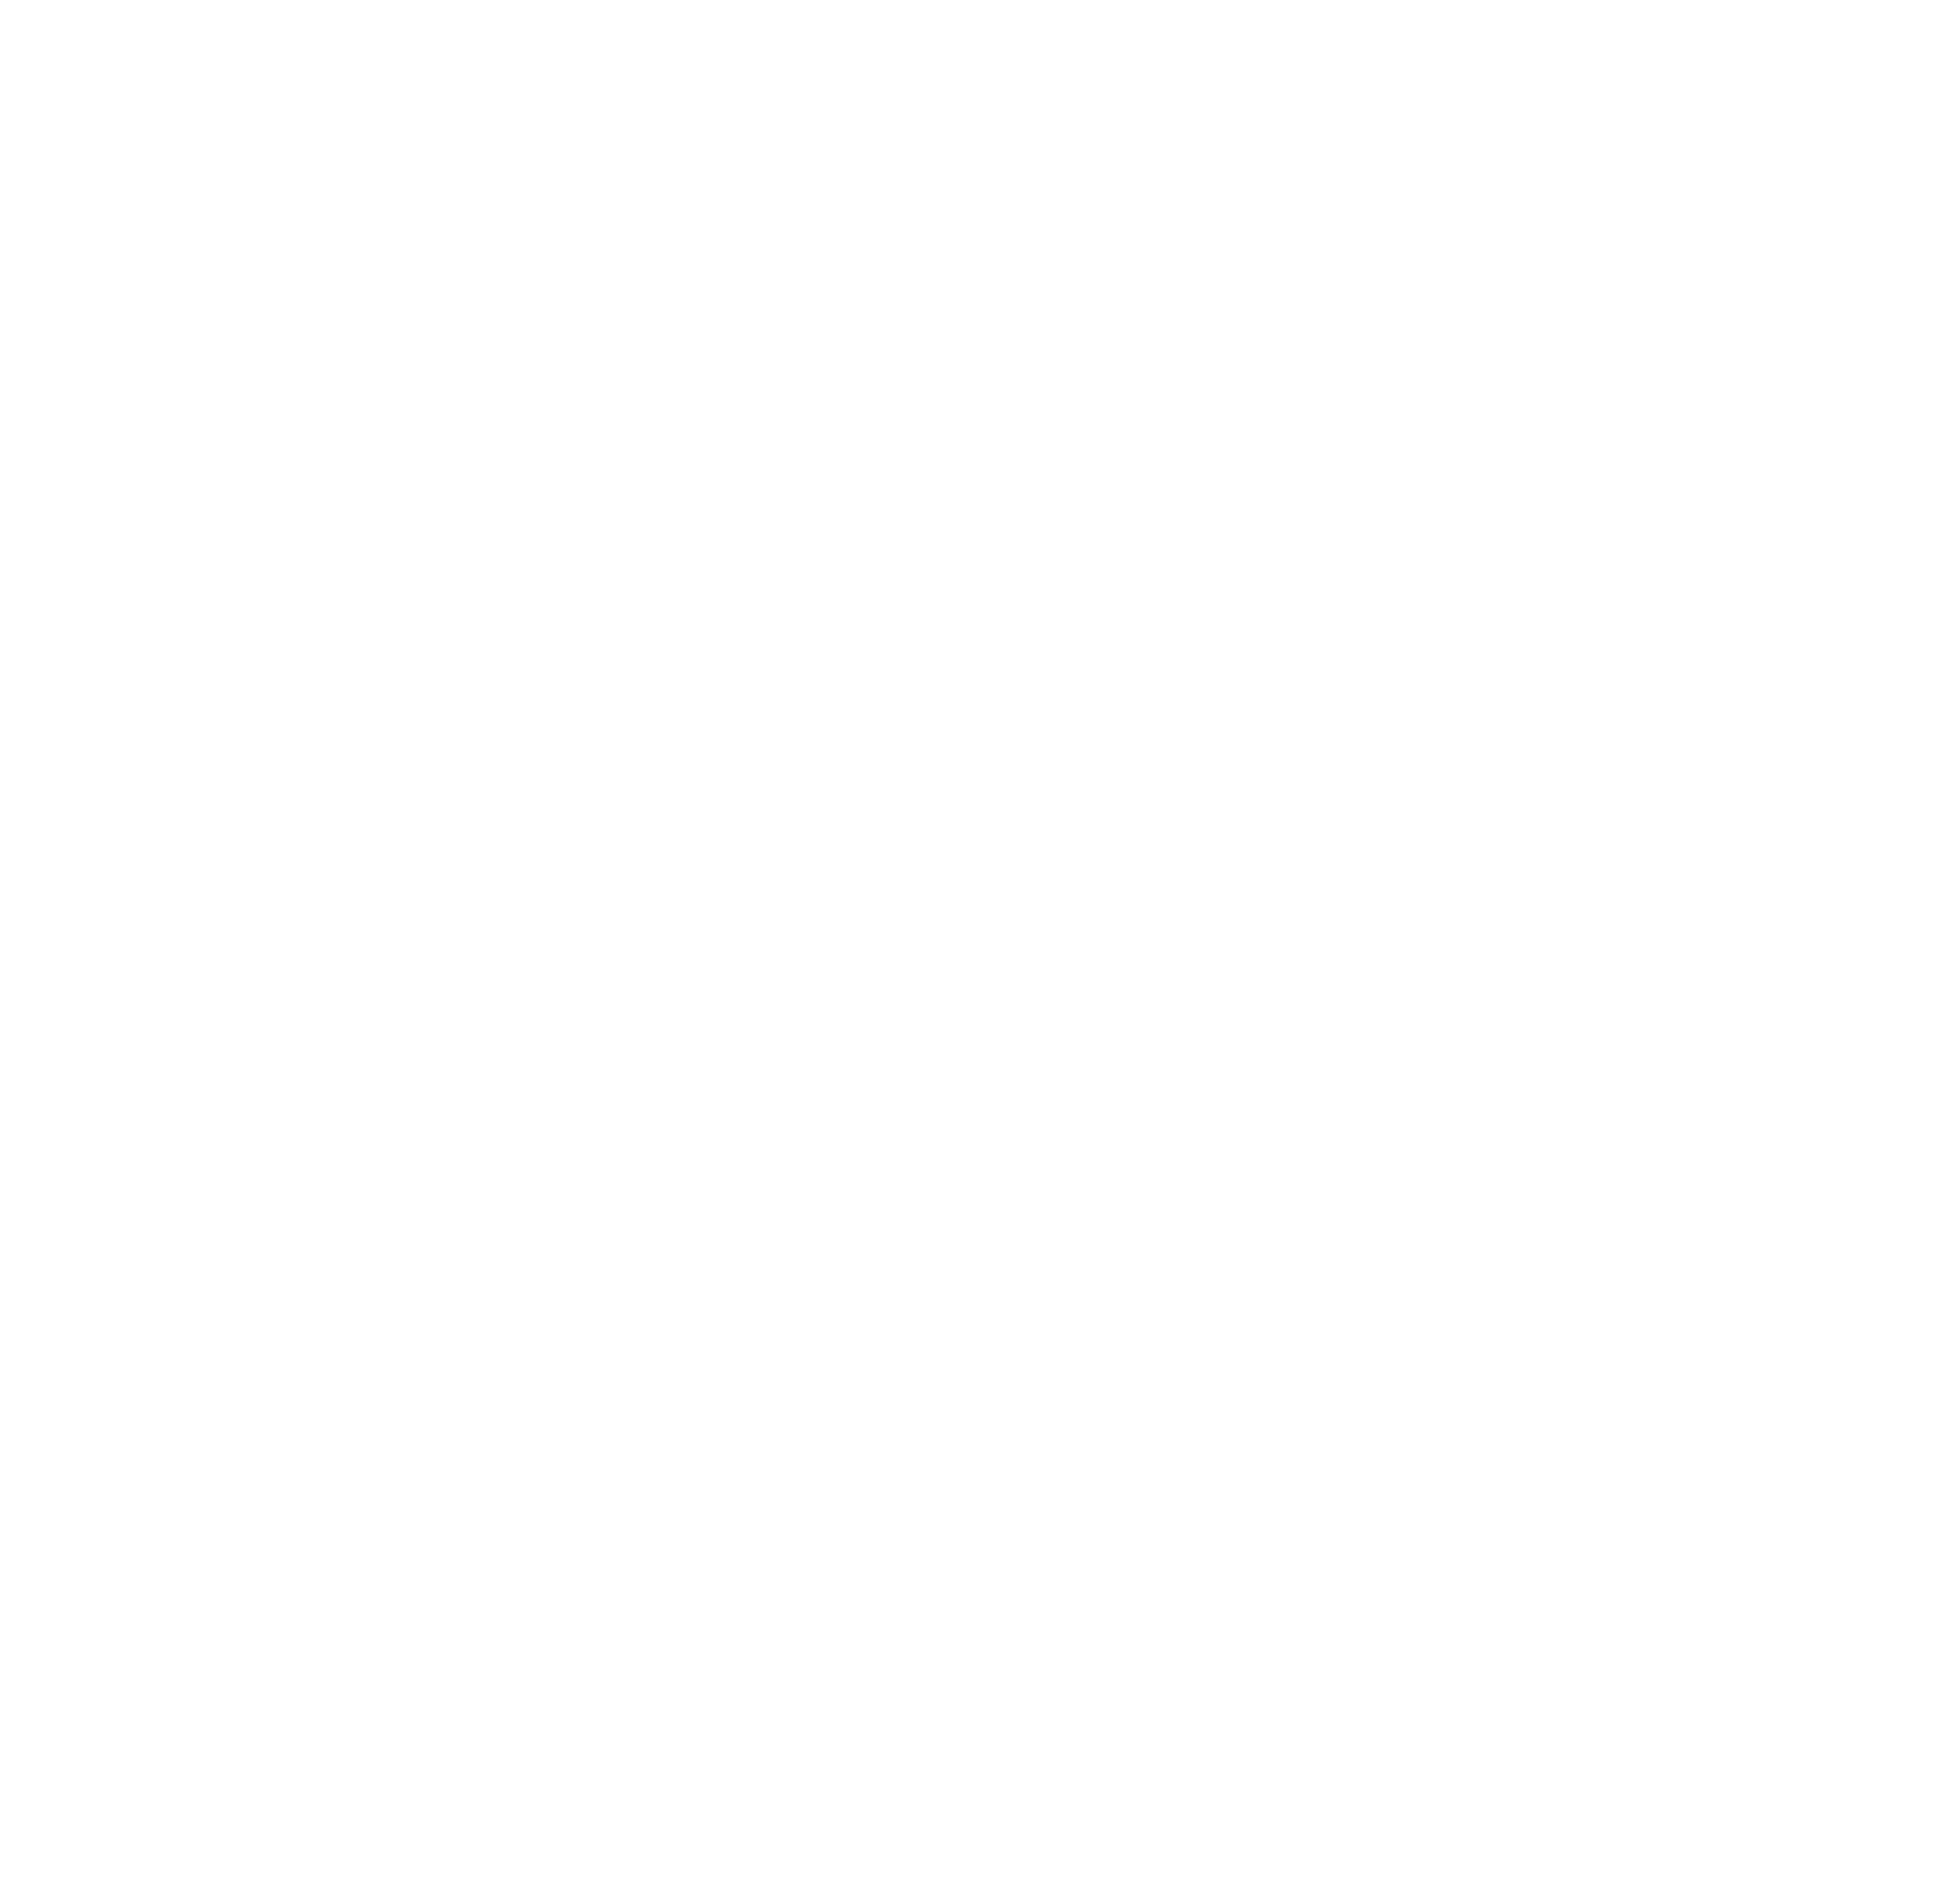

In [29]:
for topic in uniqueTopics:
    wordCloudGenerator(df, topic) #,save = True , if you want to save the Word Clouds

Feature extractions

In [30]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df[agentAssignedColumn].values)
X_train, X_test, y_train, y_test = train_test_split(df[commentTextColumn].values, y,stratify=y,random_state=42, test_size=0.1)

Tf-idf

In [31]:
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1, 3),use_idf=True,smooth_idf=True,sublinear_tf=True,stop_words = 'english')
# Fit and transform Tf-idf to both training and test sets
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

Bag of Words

In [32]:
countvec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1, 3), stop_words = 'english', binary=True)
# Fit and transform CountVectorizer to both training and test sets
countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)

# Text Classification - Supervised Approach

Now that we have cleaned text and its corresponding labels, we can start modelling step. 
First we use a `Supervised Learning` approach. The methods we use in this approach are:

- [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression): We use a pipeline approach of both [Count Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model) and [TF-IDF Vectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
- [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier): Here also, we use a pipeline approach of both [Count Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model) and [TF-IDF Vectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
- [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent): We use a pipeline approach of both [Count Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model) and [TF-IDF Vectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
- [Random Forest Classifier](https://en.wikipedia.org/wiki/Random_forest) : Here also, we use a pipeline approach of both [Count Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model) and [TF-IDF Vectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
- [XGBoost Classifier](https://en.wikipedia.org/wiki/Gradient_boosting): We use a pipeline approach of both [Count Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model) and [TF-IDF Vectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
- Combination of [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) & Logistic Regression: For using this, you'll need to download the file `GoogleNews-vectors-negative300.bin.gz` from [this location](https://code.google.com/archive/p/word2vec/)
- Combination of [Doc2Vec](https://markroxor.github.io/gensim/static/notebooks/doc2vec-wikipedia.html) & Logistic Regression: Refer [this link](https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) for a better understanding.
- Bag-Of-Words with Keras Sequential Model
- [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)
- Heuristic/Rule Based Approach.

In [33]:
print("Total Number of Words in the column "+commentTextColumn+" is "+str(df[commentTextColumn].apply(lambda x: len(x.split(' '))).sum()))

Total Number of Words in the column CustomerInteractionText is 604


In [34]:
X = df[commentTextColumn]
y = df[agentAssignedColumn]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 30)

## Logistic Regression

In [39]:
%time
logreg = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', LogisticRegression(n_jobs=1, C=1e5)),])
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=uniqueTopics))

Wall time: 998 µs
accuracy 0.8
                   precision    recall  f1-score   support

        High Bill       1.00      1.00      1.00         1
     Change Plans       0.75      0.60      0.67         5
     Add New Line       1.00      1.00      1.00         3
       Deactivate       0.80      1.00      0.89         4
           Others       1.00      0.67      0.80         3
    Roaming Plans       0.67      1.00      0.80         2
Poor Connectivity       1.00      0.67      0.80         3
         Port Out       1.00      1.00      1.00         2
   Cancel Service       0.50      0.50      0.50         4
       Data Usage       0.75      1.00      0.86         3

         accuracy                           0.80        30
        macro avg       0.85      0.84      0.83        30
     weighted avg       0.82      0.80      0.80        30



## Naive Bayes

In [40]:
%time
nb = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB(alpha=0.01)),])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=uniqueTopics))

Wall time: 0 ns
accuracy 0.7333333333333333
                   precision    recall  f1-score   support

        High Bill       0.50      1.00      0.67         1
     Change Plans       1.00      0.40      0.57         5
     Add New Line       0.67      0.67      0.67         3
       Deactivate       1.00      0.75      0.86         4
           Others       0.67      0.67      0.67         3
    Roaming Plans       0.67      1.00      0.80         2
Poor Connectivity       0.67      0.67      0.67         3
         Port Out       1.00      1.00      1.00         2
   Cancel Service       0.75      0.75      0.75         4
       Data Usage       0.60      1.00      0.75         3

         accuracy                           0.73        30
        macro avg       0.75      0.79      0.74        30
     weighted avg       0.79      0.73      0.73        30



## Stochastic Gradient Descent

In [41]:
%time
sgd = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-2, random_state=42, max_iter=5, tol=None)),])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=uniqueTopics))

Wall time: 2.99 ms
accuracy 0.8
                   precision    recall  f1-score   support

        High Bill       1.00      1.00      1.00         1
     Change Plans       0.75      0.60      0.67         5
     Add New Line       1.00      1.00      1.00         3
       Deactivate       0.67      1.00      0.80         4
           Others       1.00      0.67      0.80         3
    Roaming Plans       0.67      1.00      0.80         2
Poor Connectivity       1.00      0.67      0.80         3
         Port Out       1.00      1.00      1.00         2
   Cancel Service       0.67      0.50      0.57         4
       Data Usage       0.75      1.00      0.86         3

         accuracy                           0.80        30
        macro avg       0.85      0.84      0.83        30
     weighted avg       0.82      0.80      0.79        30



## Random Forest

In [42]:
forest = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', RandomForestClassifier(max_features='sqrt',n_estimators=1000, max_depth=3,random_state=0)),])
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=uniqueTopics))

accuracy 0.7
                   precision    recall  f1-score   support

        High Bill       0.50      1.00      0.67         1
     Change Plans       0.50      0.20      0.29         5
     Add New Line       0.75      1.00      0.86         3
       Deactivate       1.00      1.00      1.00         4
           Others       1.00      0.67      0.80         3
    Roaming Plans       0.67      1.00      0.80         2
Poor Connectivity       1.00      0.33      0.50         3
         Port Out       0.29      1.00      0.44         2
   Cancel Service       1.00      0.50      0.67         4
       Data Usage       1.00      1.00      1.00         3

         accuracy                           0.70        30
        macro avg       0.77      0.77      0.70        30
     weighted avg       0.81      0.70      0.69        30



## XGBoost

In [43]:
xgboost = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', xgb.XGBClassifier(n_jobs=1,max_depth=3,learning_rate=0.01,n_estimators=1000)),])
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=uniqueTopics))

accuracy 0.6333333333333333
                   precision    recall  f1-score   support

        High Bill       0.50      1.00      0.67         1
     Change Plans       0.50      0.20      0.29         5
     Add New Line       0.60      1.00      0.75         3
       Deactivate       1.00      0.75      0.86         4
           Others       1.00      0.67      0.80         3
    Roaming Plans       0.67      1.00      0.80         2
Poor Connectivity       0.25      0.33      0.29         3
         Port Out       0.40      1.00      0.57         2
   Cancel Service       1.00      0.50      0.67         4
       Data Usage       1.00      0.67      0.80         3

         accuracy                           0.63        30
        macro avg       0.69      0.71      0.65        30
     weighted avg       0.72      0.63      0.63        30



## Support Vector Machines(SVM)

In [45]:
from sklearn.svm import SVC

svc = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SVC(gamma='scale', decision_function_shape='ovo'))])
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=uniqueTopics))

accuracy 0.7666666666666667
                   precision    recall  f1-score   support

        High Bill       1.00      1.00      1.00         1
     Change Plans       0.67      0.40      0.50         5
     Add New Line       1.00      1.00      1.00         3
       Deactivate       1.00      1.00      1.00         4
           Others       1.00      0.67      0.80         3
    Roaming Plans       0.67      1.00      0.80         2
Poor Connectivity       1.00      0.67      0.80         3
         Port Out       0.33      1.00      0.50         2
   Cancel Service       0.67      0.50      0.57         4
       Data Usage       1.00      1.00      1.00         3

         accuracy                           0.77        30
        macro avg       0.83      0.82      0.80        30
     weighted avg       0.83      0.77      0.77        30



Checking the misclassified

In [245]:
#Evaluating Logistic Regression, since it has comparatevely better accuracy(83%)
logregclf = LogisticRegression(n_jobs=1, C=0.5)
logregclf.fit(X_train_tfidf, y_train)
y_pred = logregclf.predict(X_test_tfidf)
print("---Misclassified Examples---")
for x, y, y_hat in zip(X_test, lbl_enc.inverse_transform(y_test), lbl_enc.inverse_transform(y_pred)):
    if y != y_hat:
        print(f'Cleaned Comment: {x} | Original Topic: {y} | Predicted Topic: {y_hat}')

---Misclassified Examples---
Cleaned Comment: customer deactivate onam offer receive email sm | Original Topic: Deactivate | Predicted Topic: Change Plans
Cleaned Comment: port high bill datum plan | Original Topic: Port Out | Predicted Topic: High Bill


Learning Curve of the Model

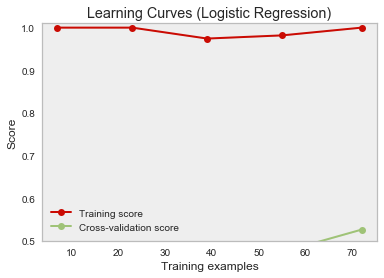

In [266]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
X, y = X_train_tfidf, y_train
title = "Learning Curves (Logistic Regression)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, (0.5, 1.01), cv=cv, n_jobs=10)
plt.show();

## Combining Word2Vec & Logistic Regression

In [278]:
%time
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)
list(islice(wv.vocab, 13030, 13050))

In [281]:
# The common way is to average the two word vectors. BOW based approaches which includes averaging.
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [284]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r[commentTextColumn]), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r[commentTextColumn]), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [286]:
%time
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train[agentAssignedColumn])
y_pred = logreg.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test[agentAssignedColumn]))
print(classification_report(test[agentAssignedColumn], y_pred,target_names=uniqueTopics))

Wall time: 0 ns


## Combining Doc2Vec & Logistic Regression

In [295]:
# Doc2vec, taking the linear combination of every term in the document creates a random walk with bias process in the word2vec space.
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [301]:
X_train, X_test, y_train, y_test = train_test_split(df[commentTextColumn], df[agentAssignedColumn], random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')

all_data = X_train + X_test
all_data[:2]

[TaggedDocument(words=['gregory', 'cancel', 'service', 'temporarily'], tags=['Train_0']),
 TaggedDocument(words=['customer', 'ask', 'data', 'usage', 'past', 'week'], tags=['Train_1'])]

In [302]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


In [315]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

logreg = LogisticRegression(n_jobs=1, C=1e9)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=uniqueTopics))

accuracy 0.43333333333333335
                   precision    recall  f1-score   support

           Others       0.50      1.00      0.67         3
   Cancel Service       0.50      0.50      0.50         2
Poor Connectivity       0.00      0.00      0.00         1
     Add New Line       1.00      0.67      0.80         3
         Port Out       0.50      0.20      0.29         5
        High Bill       0.50      0.20      0.29         5
       Deactivate       0.00      0.00      0.00         3
     Change Plans       0.33      0.50      0.40         2
    Roaming Plans       0.29      1.00      0.44         2
       Data Usage       0.67      0.50      0.57         4

         accuracy                           0.43        30
        macro avg       0.43      0.46      0.40        30
     weighted avg       0.48      0.43      0.41        30



## Bag-Of-Words with Keras

In [319]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

train_comments = df[commentTextColumn][:train_size]
train_topics = df[agentAssignedColumn][:train_size]

test_comments = df[commentTextColumn][train_size:]
test_topics = df[agentAssignedColumn][train_size:]

max_words = 500
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

Train size: 70
Test size: 30


In [321]:
%time
tokenize.fit_on_texts(train_comments) # only fit on train
x_train = tokenize.texts_to_matrix(train_comments)
x_test = tokenize.texts_to_matrix(test_comments)

encoder = LabelEncoder()
encoder.fit(train_topics)
y_train = encoder.transform(train_topics)
y_test = encoder.transform(test_topics)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Wall time: 0 ns
x_train shape: (70, 500)
x_test shape: (30, 500)
y_train shape: (70, 10)
y_test shape: (30, 10)


In [325]:
batch_size = 10
epochs = 10

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

score = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

Train on 63 samples, validate on 7 samples
Epoch 1/10
63/63 [==============================] - ETA: 1s - loss: 2.2606 - acc: 0.100 - 0s 7ms/step - loss: 2.3131 - acc: 0.0317 - val_loss: 2.3074 - val_acc: 0.1429
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 2.2625 - acc: 0.100 - ETA: 0s - loss: 2.2585 - acc: 0.200 - 0s 2ms/step - loss: 2.1982 - acc: 0.3651 - val_loss: 2.2356 - val_acc: 0.1429
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 1.9900 - acc: 0.600 - ETA: 0s - loss: 1.9986 - acc: 0.725 - 0s 2ms/step - loss: 1.9976 - acc: 0.6825 - val_loss: 2.1677 - val_acc: 0.2857
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 1.9851 - acc: 0.700 - ETA: 0s - loss: 1.9195 - acc: 0.800 - ETA: 0s - loss: 1.8807 - acc: 0.820 - 0s 3ms/step - loss: 1.8600 - acc: 0.8571 - val_loss: 2.0877 - val_acc: 0.5714
Epoch 5/10
63/63 [==============================] - ETA: 0s - loss: 1.7583 - acc: 0.900 - ETA: 0s - loss: 1.7642 - acc: 0.925 - 0s 2m

## LSTM

In [335]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 500
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 15
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df[commentTextColumn].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df[commentTextColumn].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df[agentAssignedColumn]).values
print('Shape of label tensor:', Y.shape)

Found 211 unique tokens.
Shape of data tensor: (100, 15)
Shape of label tensor: (100, 10)


In [336]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(70, 15) (70, 10)
(30, 15) (30, 10)


In [343]:
# Build the model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 100)           50000     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 15, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 131,410
Trainable params: 131,410
Non-trainable params: 0
_________________________________________________________________
None


In [349]:
epochs = 10
batch_size = 5

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Train on 63 samples, validate on 7 samples
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.0636 - acc: 1.000 - ETA: 0s - loss: 0.1069 - acc: 1.000 - ETA: 0s - loss: 0.1150 - acc: 1.000 - ETA: 0s - loss: 0.1413 - acc: 0.980 - 0s 3ms/step - loss: 0.1385 - acc: 0.9841 - val_loss: 0.5514 - val_acc: 0.8571
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.0525 - acc: 1.000 - ETA: 0s - loss: 0.0814 - acc: 1.000 - ETA: 0s - loss: 0.1318 - acc: 0.975 - ETA: 0s - loss: 0.1261 - acc: 0.966 - 0s 3ms/step - loss: 0.1361 - acc: 0.9683 - val_loss: 0.6011 - val_acc: 0.7143
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.1429 - acc: 1.000 - ETA: 0s - loss: 0.1204 - acc: 1.000 - ETA: 0s - loss: 0.1084 - acc: 1.000 - ETA: 0s - loss: 0.1255 - acc: 1.000 - ETA: 0s - loss: 0.1111 - acc: 1.000 - ETA: 0s - loss: 0.0932 - acc: 1.000 - 0s 6ms/step - loss: 0.0942 - acc: 1.0000 - val_loss: 0.4290 - val_acc: 0.8571
Epoch 4/10
63/63 [=================

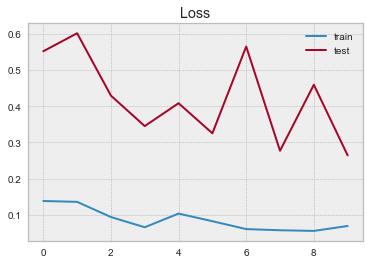

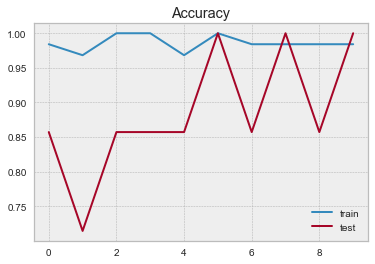

In [351]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Test with an unseen comment.

In [366]:
new_complaint = ['Avinash want to cancel service.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = uniqueTopics
print(pred, labels[np.argmax(pred)])

[[4.4254512e-03 9.2506969e-01 6.3394470e-04 2.0478480e-04 4.8004431e-03
  6.0026431e-03 1.3716313e-02 1.0041479e-02 3.2136165e-02 2.9691118e-03]] Cancel Service


## Heuristic/Rule Based Approach

In [422]:
def removeFrequentOccuringWords(wordList):
    commonWords = ['customer', 'want', 'plan', 'month', 'new', 'inquire', 'check']
    wordList = [word for word in wordList if word not in commonWords]
    return ','.join(wordList)

In [423]:
labelsKeywords = pd.DataFrame(columns = ['Label', 'Fuzzy Words', 'Strict Words'])

labelColumnList = list(df[agentAssignedColumn].value_counts().to_dict())
strictWordList = ['']
fuzzyWordList = ['']
for reasoncode in labelColumnList:
    fuzzyWordList.append(','.join(removeFrequentOccuringWords(wordFrequencyListPlot(reasoncode)).split(',')[-2:]))
    strictWordList.append(','.join(removeFrequentOccuringWords(wordFrequencyListPlot(reasoncode)).split(',')[:6]))

labelsKeywords['Label'] = ['Others'] + labelColumnList
labelsKeywords['Fuzzy Words'] = fuzzyWordList
labelsKeywords['Strict Words'] = strictWordList
labelsKeywords.head()

['speed', 'connection', 'connectivity', 'poor', 'customer', 'area', 'device', 'issue', 'low', 'face']
['speed', 'connection', 'connectivity', 'poor', 'customer', 'area', 'device', 'issue', 'low', 'face']
['port', 'customer', 'want', 'transfer', 'plan', 'service', 'ask', 'retain', 'porting', 'cancel']
['port', 'customer', 'want', 'transfer', 'plan', 'service', 'ask', 'retain', 'porting', 'cancel']
['cancel', 'service', 'customer', 'want', 'exist', 'new', 'plan', 'effect', 'celebration', 'add']
['cancel', 'service', 'customer', 'want', 'exist', 'new', 'plan', 'effect', 'celebration', 'add']
['usage', 'datum', 'customer', 'data', 'month', 'match', 'business', 'provide', 'balance', 'increase']
['usage', 'datum', 'customer', 'data', 'month', 'match', 'business', 'provide', 'balance', 'increase']
['bill', 'high', 'month', 'want', 'plan', 'customer', 'complain', 'monthly', 'afford', 'expensive']
['bill', 'high', 'month', 'want', 'plan', 'customer', 'complain', 'monthly', 'afford', 'expensive'

,Label,Fuzzy Words,Strict Words
0,Others,,
1,Poor Connectivity,"low,face","speed,connection,connectivity,poor,area,device"
2,Port Out,"porting,cancel","port,transfer,service,ask,retain,porting"
3,Cancel Service,"celebration,add","cancel,service,exist,effect,celebration,add"
4,Data Usage,"balance,increase","usage,datum,data,match,business,provide"


In [424]:
def find_best_label(TrainingWords, StrictWords, text_in):   
    clnTxt = [st.stem(u.lower()) for u in  text_in.split()]        
    if(len(clnTxt)==0):
        clnTxt =  'Others'     
    NL = len(TrainingWords)
    probV = [0.0 for k in range(NL)]
    CM_A = []
    for j in range(NL):
        TrSet = set([ st.stem(u.lower())  for u in TrainingWords[j].split()])
        SWords = set([ u.lower().strip() for u in StrictWords[j].split(",")])  if len(StrictWords[j]) else []
        matching =  [s for s in SWords  if ((s in text_in) and len(set(s.split()).intersection(text_in.split()))==len(s.split())) ] 
        cm = list(TrSet.intersection(clnTxt))
        if len(matching)>0:
            probV[j] = 1
            CM_A.append(matching)
            break
        else:                
            if len(cm):
                CM_A.append(cm)
            else:
                CM_A.append([])
            probV[j] = (len(cm)/float(len(clnTxt)))
    return({'idx':np.argmax(probV), 'maxV':np.max(probV), 'wa':CM_A[np.argmax(probV)]})

In [425]:
%time
TestData = df.copy()
test_buffer = TestData.iloc[:,1]

TrainingData = labelsKeywords.copy()

fuzzy_word_list = TrainingData['Fuzzy Words']
strict_word_list = TrainingData['Strict Words']
train_buffer = [fuzzy_word_list[i]+" "+strict_word_list[i] for i in range(len(TrainingData))]

Labels = [a for a in TrainingData['Label']]

TestData['New Topic'] = 0.0
TestData['Conf'] = 0.0
TestData['Matching words'] = ["" for i in range(len(TestData))]

for i in range(len(test_buffer)):
    BL = find_best_label(train_buffer, TrainingData['Strict Words'], test_buffer[i])
    TestData['New Topic'][i] = Labels[BL['idx']]
    TestData['Conf'][i] = BL['maxV']
    TestData['Matching words'][i] = ", ".join(BL['wa'])    
    
TestData.head()

Wall time: 0 ns


,RecordID,CustomerInteractionRawText,AgentAssignedTopic,LocationID,CallDurationSeconds,AgentID,CustomerID,CustomerInteractionText,totalwords,language,New Topic,Conf,Matching words
92,1890133,Reported sad demise of customer.,Others,2.0,19.0,o6cXs,jD51a,report sad demise customer,5,en,Others,1.0,demise
76,1890117,Customer inquired about the cacellation policies.,Cancel Service,0.0,13.0,NvHk7,0Y5rx,customer inquire cacellation policy,6,en,Others,0.0,
11,1890052,Low speed connection reported in Uppala area.,Poor Connectivity,3.0,17.0,eUYn2,movRl,low speed connection report area,7,en,Poor Connectivity,1.0,"speed, connection"
40,1890081,68347585642 want to add a new connection.,Add New Line,3.0,14.0,D3KmX,8wxr3,want add new connection,7,en,Cancel Service,1.0,add
18,1890059,Customer facing issues in connectivity from ye...,Poor Connectivity,5.0,13.0,0mj3N,r34oU,customer face issue connectivity yesterday onw...,10,en,Poor Connectivity,1.0,connectivity


In [426]:
originalTopic = TestData[agentAssignedColumn]
newTopic = TestData['New Topic']

print('accuracy %s' % accuracy_score(newTopic, originalTopic))
print(classification_report(originalTopic, newTopic,target_names=uniqueTopics))

accuracy 0.57
                   precision    recall  f1-score   support

           Others       0.60      0.30      0.40        10
   Cancel Service       0.40      0.40      0.40        10
Poor Connectivity       0.70      0.70      0.70        10
     Add New Line       0.88      0.70      0.78        10
         Port Out       1.00      0.40      0.57        10
        High Bill       1.00      0.80      0.89        10
       Deactivate       0.26      0.80      0.39        10
     Change Plans       0.69      0.90      0.78        10
    Roaming Plans       0.64      0.70      0.67        10
       Data Usage       0.00      0.00      0.00        10

         accuracy                           0.57       100
        macro avg       0.62      0.57      0.56       100
     weighted avg       0.62      0.57      0.56       100



# Text Classification - Unsupervised Approach

We also try an `Unsupervised Learning` approach. [Latent Dirichlet allocation(LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is used to get the topic clusters. We use two types of Word Corpuses:
- Bag of Words
- TF-IDF


In trying to incorporate the context of sentences at times, we also try two word gram models:
- Unigram Word distribution
- Bigram Word distribution

## Topic Modelling using LDA

In [498]:
#Gensim Preprocessing
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = df[commentTextColumn].map(preprocess)
processed_docs[:5]

92                              [report, demis, custom]
76                      [custom, inquir, cacel, polici]
11                       [speed, connect, report, area]
40                                      [want, connect]
18    [custom, face, issu, connect, yesterday, onwar...
Name: CustomerInteractionText, dtype: object

### LDA Using Bag-of-Words

- Unigram Bag of Words 

In [458]:
%time
#Modelling Step
NUM_TOPICS = len(uniqueTopics) #10 here
print("\n Number of topics = "+str(NUM_TOPICS)+" \n")
sizeDf=str(len(df))

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes()
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary, workers = 2, passes = 5, iterations = 100, eval_every=5)

# # Saving the Model
# modelFileName = 'bowGensimModel'+sizeDf+'('+str(NUM_TOPICS)+').gensim'
# lda_model_bow.save(modelFileName)
# print('\n Model Saved as: '+modelFileName)

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Wall time: 0 ns

 Number of topics = 10 




 Model Saved as: bowGensimModel100(10).gensim
Topic: 0 
Words: 0.267*"roam" + 0.186*"custom" + 0.159*"charg" + 0.132*"check" + 0.115*"plan" + 0.054*"chang" + 0.036*"want" + 0.004*"high" + 0.004*"connect" + 0.004*"speed"
Topic: 1 
Words: 0.403*"connect" + 0.349*"want" + 0.094*"cancel" + 0.049*"report" + 0.011*"roam" + 0.008*"custom" + 0.006*"plan" + 0.006*"check" + 0.006*"servic" + 0.004*"current"
Topic: 2 
Words: 0.428*"custom" + 0.255*"line" + 0.102*"offer" + 0.064*"deactiv" + 0.040*"plan" + 0.040*"want" + 0.011*"high" + 0.006*"month" + 0.004*"cancel" + 0.004*"servic"
Topic: 3 
Words: 0.211*"cancel" + 0.209*"custom" + 0.197*"servic" + 0.130*"want" + 0.087*"exist" + 0.052*"plan" + 0.044*"port" + 0.028*"deactiv" + 0.004*"usag" + 0.004*"datum"
Topic: 4 
Words: 0.297*"usag" + 0.204*"datum" + 0.159*"custom" + 0.084*"want" + 0.046*"check" + 0.044*"devic" + 0.044*"month" + 0.037*"know" + 0.025*"report" + 0.024*"plan"
Topic: 5 
Words: 0.231*"connect" + 0.183*"speed" + 0.144*"want" + 0.138*"c

In [459]:
%time
lda_display = gensimvis.prepare(lda_model_bow, bow_corpus, dictionary, sort_topics = False)

# #If you want to save the visualization
# pyLDAvis.save_html(lda_display, 'bowGensimModel'+str(NUM_TOPICS)+'.html')

pyLDAvis.display(lda_display)

Wall time: 0 ns


In [472]:
%time
# Based on the Dirichlet Equations, these could be a possible Topic Assignments
TopicList= {0:'Roaming Plans',
1:'Others',
2:'Add New Line',
3:'Cancel Service',
4:'Data Usage',
5:'Poor Connectivity',
6:'High Bill',
7:'Deactivate',
8:'Change Plans',
9:'Port Out'}


df['topicNumDistributionColumn'] = lda_model_bow.get_document_topics(bow_corpus, minimum_probability=0.1)

topiclist = df['topicNumDistributionColumn'].tolist()
newTopic = []
for element in topiclist: 
    newTopic.append(str(sorted(element, key=lambda x: -x[1])[-1:]))
    
df['NewTopic'] = newTopic



topicExpansionInNumberPrimary = []
for item in df['NewTopic']:
    itemToList = re.findall(r'\d+', item)
    if len(itemToList)==3:
        topicExpansionInNumberPrimary.append(TopicList[int(itemToList[0])])
    elif len(itemToList)==0:
        topicExpansionInNumberPrimary.append(None)
    else:
        topicExpansionInNumberPrimary.append(None)
df['NewTopic'] = topicExpansionInNumberPrimary

originalTopic = df[agentAssignedColumn]
newTopic = df['NewTopic']

print('accuracy %s' % accuracy_score(newTopic, originalTopic))
print(classification_report(originalTopic, newTopic,target_names=uniqueTopics))

Wall time: 0 ns
accuracy 0.52
                   precision    recall  f1-score   support

           Others       0.39      0.70      0.50        10
   Cancel Service       0.67      0.80      0.73        10
Poor Connectivity       0.36      0.40      0.38        10
     Add New Line       1.00      0.90      0.95        10
         Port Out       0.33      0.30      0.32        10
        High Bill       0.50      0.10      0.17        10
       Deactivate       0.30      0.30      0.30        10
     Change Plans       0.71      0.50      0.59        10
    Roaming Plans       0.36      0.40      0.38        10
       Data Usage       0.73      0.80      0.76        10

         accuracy                           0.52       100
        macro avg       0.54      0.52      0.51       100
     weighted avg       0.54      0.52      0.51       100



- Bi gram Bag of Words

In [488]:
processed_docs = df[commentTextColumn].to_list()
token_ = [doc.split(" ") for doc in processed_docs]
bigram = Phrases(token_, min_count=1, threshold=2,delimiter=b' ')


bigram_phraser = Phraser(bigram)

bigram_token = []
for sent in token_:
    bigram_token.append(bigram_phraser[sent])

#now you can make dictionary of bigram token 
dictBigram = gensim.corpora.Dictionary(bigram_token)
# dictBigram.filter_extremes(no_above=0.5, keep_n=100000)

#Convert the word into vector, and now you can use from gensim 
bow_corpus_bigram = [dictBigram.doc2bow(text) for text in bigram_token]

In [492]:
lda_model_bow_bigram = gensim.models.LdaMulticore(bow_corpus_bigram, num_topics=NUM_TOPICS, id2word=dictBigram, workers = 2, passes = 5, iterations = 100, eval_every=5)

# # Saving the Model
# modelFileName = 'bowGensimModelBigram'+sizeDf+'('+str(NUM_TOPICS)+').gensim'
# lda_model_bow_bigram.save(modelFileName)
# print('\n Model Saved as: '+modelFileName)

for idx, topic in lda_model_bow_bigram.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.036*"want" + 0.036*"plan" + 0.019*"poor connectivity" + 0.019*"port" + 0.019*"service" + 0.019*"option" + 0.019*"speed" + 0.019*"time customer" + 0.019*"low" + 0.019*"increase"
Topic: 1 
Words: 0.022*"connection speed" + 0.022*"ask" + 0.022*"change plan" + 0.022*"customer want" + 0.022*"roam charge" + 0.022*"check" + 0.022*"current plan" + 0.022*"device" + 0.022*"datum plan" + 0.022*"want"
Topic: 2 
Words: 0.050*"month" + 0.034*"high" + 0.034*"customer" + 0.033*"exist plan" + 0.018*"demise" + 0.018*"want know" + 0.018*"new plan" + 0.018*"roam charge" + 0.018*"afford" + 0.018*"high bill"
Topic: 3 
Words: 0.042*"customer" + 0.042*"line" + 0.042*"add new" + 0.028*"offer" + 0.028*"complain" + 0.015*"usage" + 0.015*"new plan" + 0.015*"want cancel" + 0.015*"increase" + 0.015*"customer inquire"
Topic: 4 
Words: 0.060*"plan" + 0.026*"connection" + 0.026*"ask" + 0.026*"report" + 0.026*"want change" + 0.026*"recent" + 0.026*"detail" + 0.026*"add new" + 0.026*"customer" + 0.023

### LDA Using TF-IDF

- Unigram TFIDF

In [499]:
%time
#Modelling Step
NUM_TOPICS = len(uniqueTopics) #10 here
print("\n Number of topics = "+str(NUM_TOPICS)+" \n")
sizeDf=str(len(df))

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes()
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=5, workers=2, iterations = 100, eval_every=5)
# # Saving the Model
# modelFileName = 'tfidfGensimModel'+sizeDf+'('+str(NUM_TOPICS)+').gensim'
# lda_model_bow.save(modelFileName)
# print('\n Model Saved as: '+modelFileName)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Wall time: 0 ns

 Number of topics = 10 



Topic: 0 
Words: 0.328*"month" + 0.305*"high" + 0.083*"want" + 0.068*"custom" + 0.063*"plan" + 0.037*"cancel" + 0.008*"usag" + 0.008*"connect" + 0.008*"report" + 0.007*"current"
Topic: 1 
Words: 0.267*"roam" + 0.187*"charg" + 0.099*"devic" + 0.066*"check" + 0.062*"plan" + 0.058*"custom" + 0.047*"month" + 0.047*"want" + 0.046*"high" + 0.037*"know"
Topic: 2 
Words: 0.608*"check" + 0.037*"datum" + 0.035*"month" + 0.033*"usag" + 0.023*"charg" + 0.019*"want" + 0.018*"connect" + 0.016*"roam" + 0.015*"chang" + 0.014*"custom"
Topic: 3 
Words: 0.250*"chang" + 0.193*"plan" + 0.165*"offer" + 0.123*"current" + 0.080*"deactiv" + 0.056*"want" + 0.052*"custom" + 0.020*"datum" + 0.007*"speed" + 0.006*"roam"
Topic: 4 
Words: 0.279*"cancel" + 0.216*"report" + 0.183*"servic" + 0.123*"want" + 0.061*"connect" + 0.018*"datum" + 0.017*"usag" + 0.013*"month" + 0.007*"offer" + 0.007*"chang"
Topic: 5 
Words: 0.398*"connect" + 0.255*"speed" + 0.092*"want" + 0.074*"devic" + 0.054*"custom" + 0.008*"current" + 0.00

In [500]:
%time
lda_display = gensimvis.prepare(lda_model_tfidf, corpus_tfidf, dictionary, sort_topics = False)

# #If you want to save the visualization
# pyLDAvis.save_html(lda_display, 'tfidfGensimModel'+str(NUM_TOPICS)+'.html')

pyLDAvis.display(lda_display)

Wall time: 0 ns


In [502]:
%time
# Based on the Dirichlet Equations, these could be a possible Topic Assignments
TopicList= {0:'High Bill',
1:'Roaming Plans',
2:'Others',
3:'Change Plans',
4:'Cancel Service',
5:'Poor Connectivity',
6:'Add New Line',
7:'Port Out',
8:'Data Usage',
9:'Deactivate'}


df['topicNumDistributionColumn'] = lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability=0.1)

topiclist = df['topicNumDistributionColumn'].tolist()
newTopic = []
for element in topiclist: 
    newTopic.append(str(sorted(element, key=lambda x: -x[1])[-1:]))
    
df['NewTopic'] = newTopic



topicExpansionInNumberPrimary = []
for item in df['NewTopic']:
    itemToList = re.findall(r'\d+', item)
    if len(itemToList)==3:
        topicExpansionInNumberPrimary.append(TopicList[int(itemToList[0])])
    elif len(itemToList)==0:
        topicExpansionInNumberPrimary.append(None)
    else:
        topicExpansionInNumberPrimary.append(None)
df['NewTopic'] = topicExpansionInNumberPrimary

originalTopic = df[agentAssignedColumn]
newTopic = df['NewTopic']

print('accuracy %s' % accuracy_score(newTopic, originalTopic))
print(classification_report(originalTopic, newTopic,target_names=uniqueTopics))

Wall time: 0 ns
accuracy 0.6
                   precision    recall  f1-score   support

           Others       1.00      0.80      0.89        10
   Cancel Service       0.50      0.40      0.44        10
Poor Connectivity       0.53      0.90      0.67        10
     Add New Line       0.75      0.60      0.67        10
         Port Out       0.11      0.10      0.11        10
        High Bill       0.75      0.90      0.82        10
       Deactivate       0.33      0.20      0.25        10
     Change Plans       0.60      0.60      0.60        10
    Roaming Plans       0.62      0.80      0.70        10
       Data Usage       0.78      0.70      0.74        10

         accuracy                           0.60       100
        macro avg       0.60      0.60      0.59       100
     weighted avg       0.60      0.60      0.59       100



- Bigram TFIDF

In [504]:
processed_docs = df[commentTextColumn].to_list()
token_ = [doc.split(" ") for doc in processed_docs]
bigram = Phrases(token_, min_count=1, threshold=2,delimiter=b' ')


bigram_phraser = Phraser(bigram)

bigram_token = []
for sent in token_:
    bigram_token.append(bigram_phraser[sent])

#now you can make dictionary of bigram token 
dictBigram = gensim.corpora.Dictionary(bigram_token)
# dictBigram.filter_extremes(no_above=0.5, keep_n=100000)

#Convert the word into vector, and now you can use from gensim 
corpus_bigram = [dictBigram.doc2bow(text) for text in bigram_token]

tfidf_model_bigram = models.TfidfModel(corpus_bigram)
corpus_tfidf_bigram = tfidf_model_bigram[corpus_bigram]

In [505]:
lda_model_tfidf_bigram = gensim.models.LdaMulticore(corpus_tfidf_bigram, num_topics=NUM_TOPICS, id2word=dictBigram, passes=5, workers=2, iterations = 100, eval_every=5)
# # Saving the Model
# modelFileName = 'tfidfGensimModelBigram'+sizeDf+'('+str(NUM_TOPICS)+').gensim'
# lda_model_bow.save(modelFileName)
# print('\n Model Saved as: '+modelFileName)

for idx, topic in lda_model_tfidf_bigram.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"roam charge" + 0.018*"status" + 0.018*"tour" + 0.017*"temporarily" + 0.017*"gregory" + 0.017*"business" + 0.016*"imei" + 0.016*"member" + 0.016*"family" + 0.015*"stop"
Topic: 1 
Words: 0.019*"retain" + 0.017*"low" + 0.016*"customer want" + 0.016*"transfer" + 0.016*"want" + 0.016*"speed" + 0.015*"port" + 0.014*"instal" + 0.013*"cacellation" + 0.013*"terminate"
Topic: 2 
Words: 0.036*"connection speed" + 0.021*"new plan" + 0.020*"complain" + 0.018*"month" + 0.018*"happy" + 0.016*"check" + 0.015*"provide" + 0.015*"match actual" + 0.015*"quality" + 0.015*"average"
Topic: 3 
Words: 0.023*"line" + 0.022*"national" + 0.021*"add new" + 0.018*"speed mbps" + 0.018*"upgrade" + 0.018*"insufficient" + 0.017*"customer inquire" + 0.017*"value" + 0.017*"cancel" + 0.016*"customer want"
Topic: 4 
Words: 0.027*"imei" + 0.025*"travel" + 0.024*"change" + 0.022*"week" + 0.021*"region" + 0.019*"customer" + 0.018*"ask" + 0.016*"inform" + 0.015*"suspend" + 0.015*"celebration"
Topic: 5 


## Some Useful References:

- [Analytics Vidya](https://www.analyticsvidhya.com/blog/2017/01/ultimate-guide-to-understand-implement-natural-language-processing-codes-in-python/) for Preprocessing
- [Blog post](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24) by Susan Li.
- [Analytics Vidya](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/) for Topic Modelling.
- [Machine Learning Plus](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)